In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.data import DataLoader

from tqdm import tqdm
from geomloss import SamplesLoss

from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from contrib.handcrafted_data import syn_dataset
from vectran.data.graphics_primitives import PrimitiveType
from utils import (
    SyntheticPatch, LinePerturbationPipe, LineBatchRandomShift, torch_to_synthetic_lines
)

from stateful_batch_aligner import (
    StatefulBatchAligner, 
    LossComposition, 
    init_ot_aligner,
    make_default_loss_fn,
    make_default_optimize_fn,
    store_render_difference,
    strip_confidence_grads,
#     save_best_batch
)
from crossing_refiner import CrossingRefinerFull

DEVICE = 'cuda:1'

In [2]:
def compose(*fns):
    def composition(state):
        result = None
        for fn in fns:
            result = fn(state)
        return result    
            
    return composition


def coords_only_grads(n_steps=200):
    def fn(state):
        if state['current_step'] < n_steps:
            state['current_line_batch'].grad.data[:, :, 4] = 0.
    return fn


def reduced_width_lr(multiplier=0.2):
    def fn(state):
        state['current_line_batch'].grad.data[:, :, 4] *= multiplier
    return fn


def not_too_thin(state):
    return torch.sum(torch.relu(1. - state['current_line_batch'][:, :, 4]))


def perceptual_bce(model, n_convolutions=2, weight=1.0):
    bce = torch.nn.BCEWithLogitsLoss(reduction='none')
    def fn(state):
        render = model.apply_convolutions(state['render'].unsqueeze(1), n_convolutions)
        raster = model.apply_convolutions(state['raster'].unsqueeze(1), n_convolutions)
        result = weight * bce(render, raster).mean(dim=(1, 2, 3)).sum()
        return result
    
    return fn

In [3]:
model = CrossingRefinerFull().to(DEVICE)
model.load_state_dict(torch.load('best_crossings_good_backup.pt'))
_ = model.train(False)

In [4]:
np.random.seed(4)
dataloader = DataLoader(syn_dataset, batch_size=32)

perturber = LinePerturbationPipe(
    LineBatchRandomShift((-6, 6), (0, 1)),
)

n_steps = 300

loss = LossComposition()
ot_loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.6, reach=6.)
loss.add(make_default_loss_fn(bce_schedule=(lambda state: 0.0), ot_loss=ot_loss))
# loss.add(not_too_thin)
loss.add(perceptual_bce(model, 3))
loss.add(perceptual_bce(model, 4))

aligner = None

for i, batch in enumerate(dataloader):
    vectors = perturber.transform(batch['vector'][PrimitiveType.PT_LINE].type(torch.float32)).to(DEVICE)
    rasters = 1. - batch['raster'].to(DEVICE)
    
    rasters = model.forward(rasters.unsqueeze(1)).squeeze(1).detach()
    rasters /= rasters.max(dim=2, keepdim=True).values.max(dim=1, keepdim=True).values
    
    grad_transformer = compose(strip_confidence_grads, coords_only_grads(n_steps - 100))
    
    aligner = StatefulBatchAligner(vectors, rasters, device=DEVICE)
    init_ot_aligner(aligner, loss_fn=loss, device=DEVICE,
                    optimize_fn=make_default_optimize_fn(
                        aligner, 
                        lr=0.25, 
                        transform_grads=grad_transformer,
                        base_optimizer=optim.Adam,
                    ))
    
    aligner.add_callback(store_render_difference)
    
    for _ in tqdm(range(n_steps)):
        aligner.step()
    
    if i == 0:
        break

/home/apankov/FloorplanVectorization/vectran/data/syndata/snapping.py:31: UserWarning: failed to snap Line(start=(613.1611371594772+11132.305188391876j), end=(23.330485612087983-122.33409639554493j)) to Line(start=(21.45045574430263+43.528638681277315j), end=(-88.07013749668977+165.163580166241j))
  warn('failed to snap {} to {}'.format(line_svg, second_svg[-1]))
100%|██████████| 300/300 [02:46<00:00,  1.80it/s]


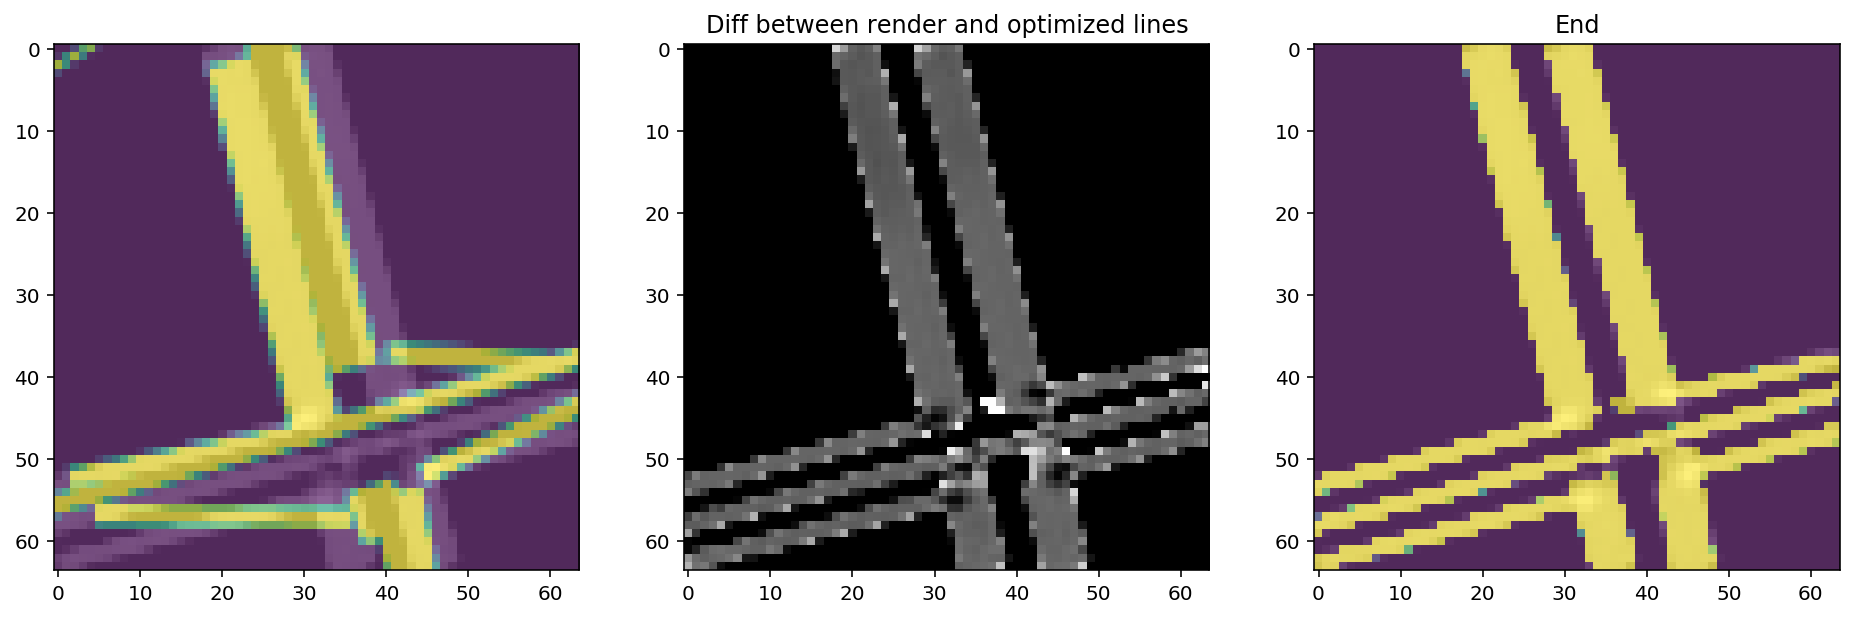

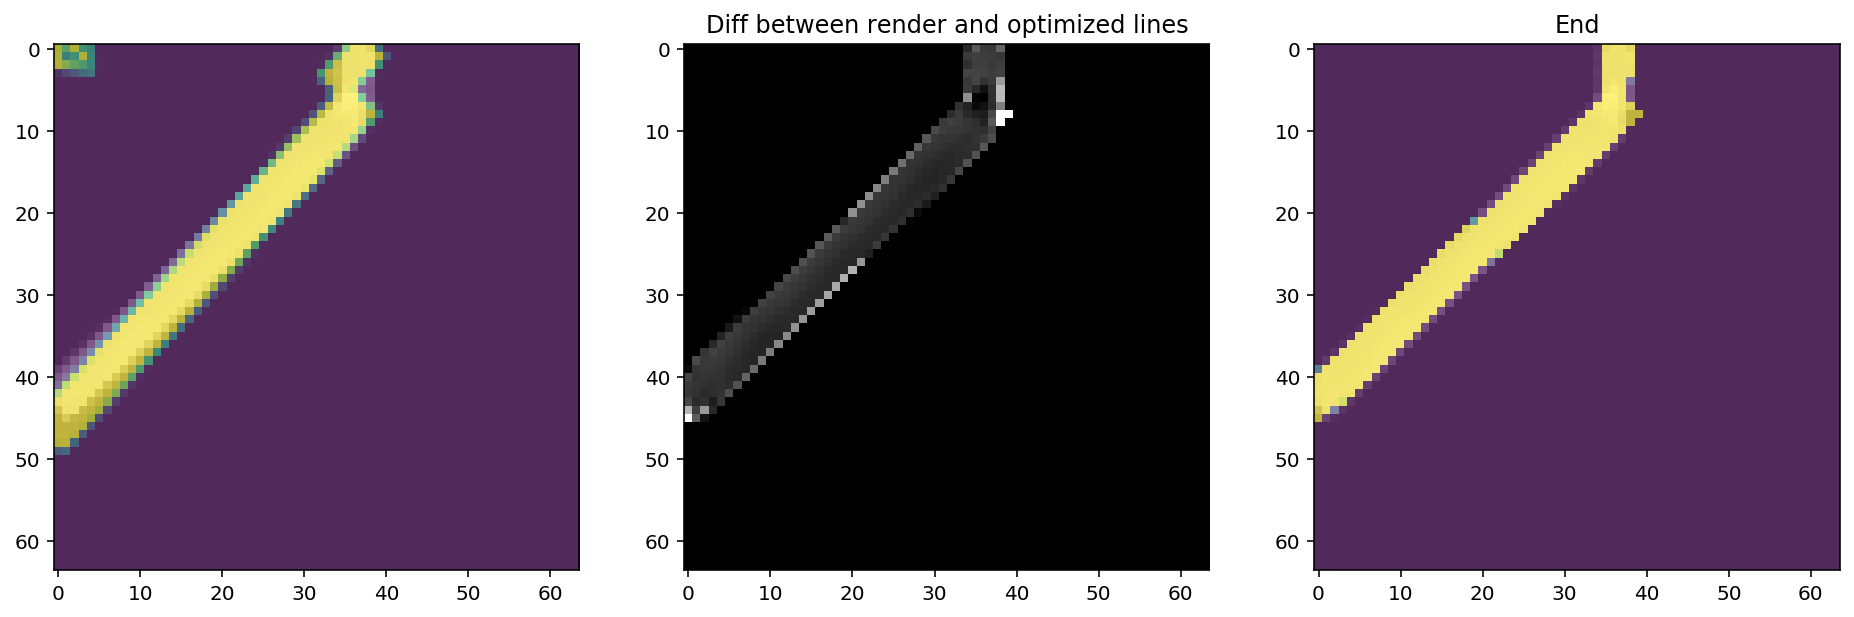

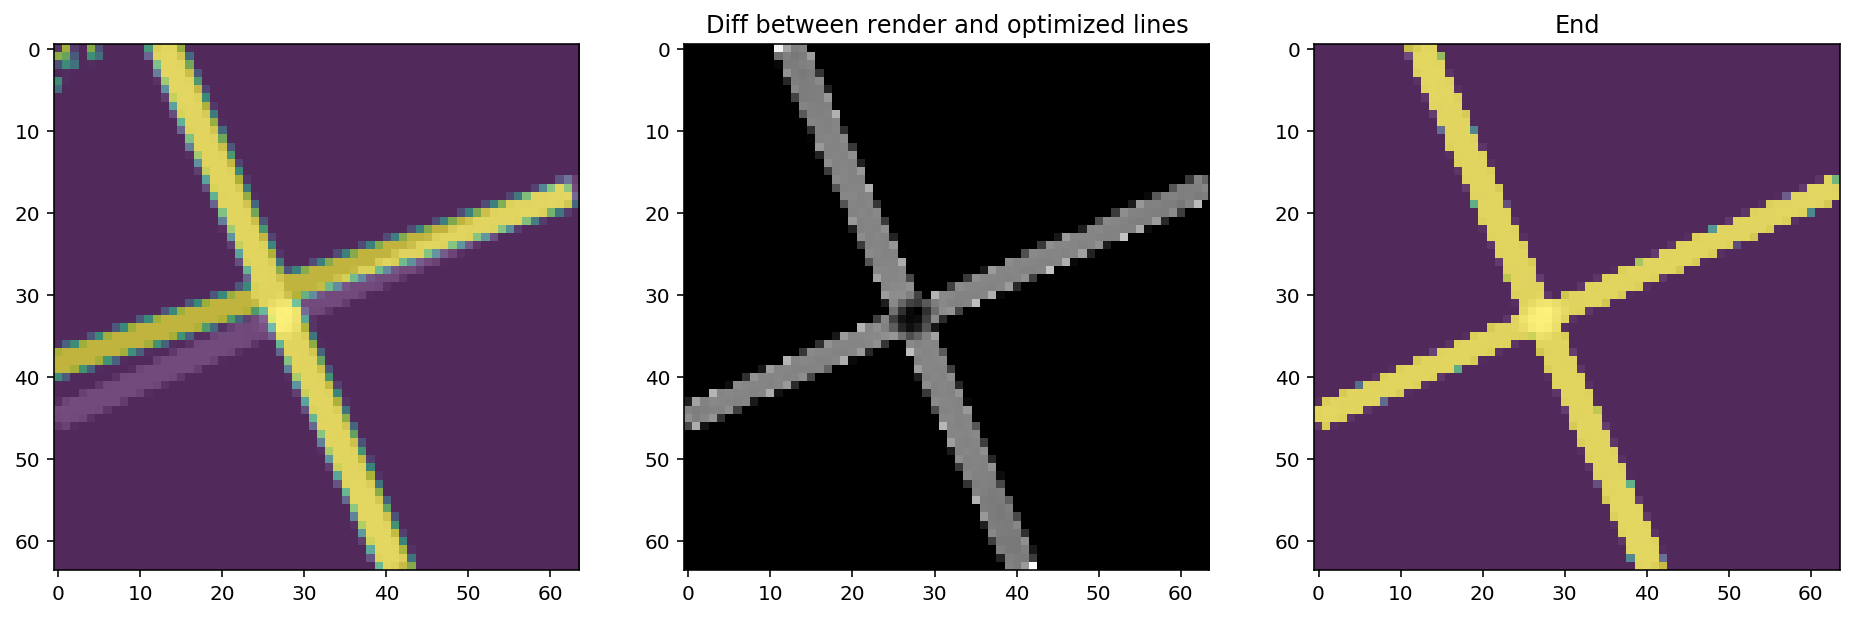

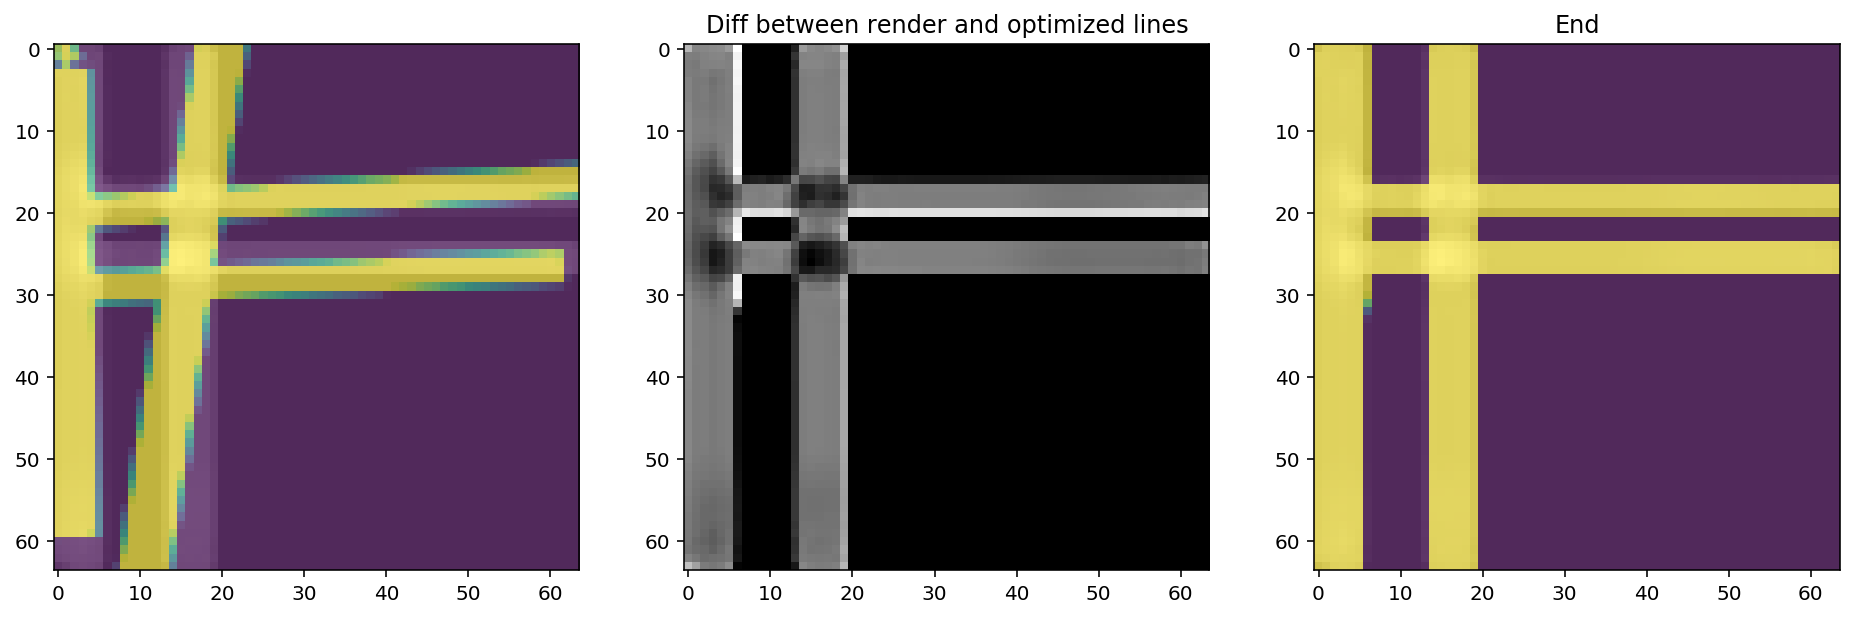

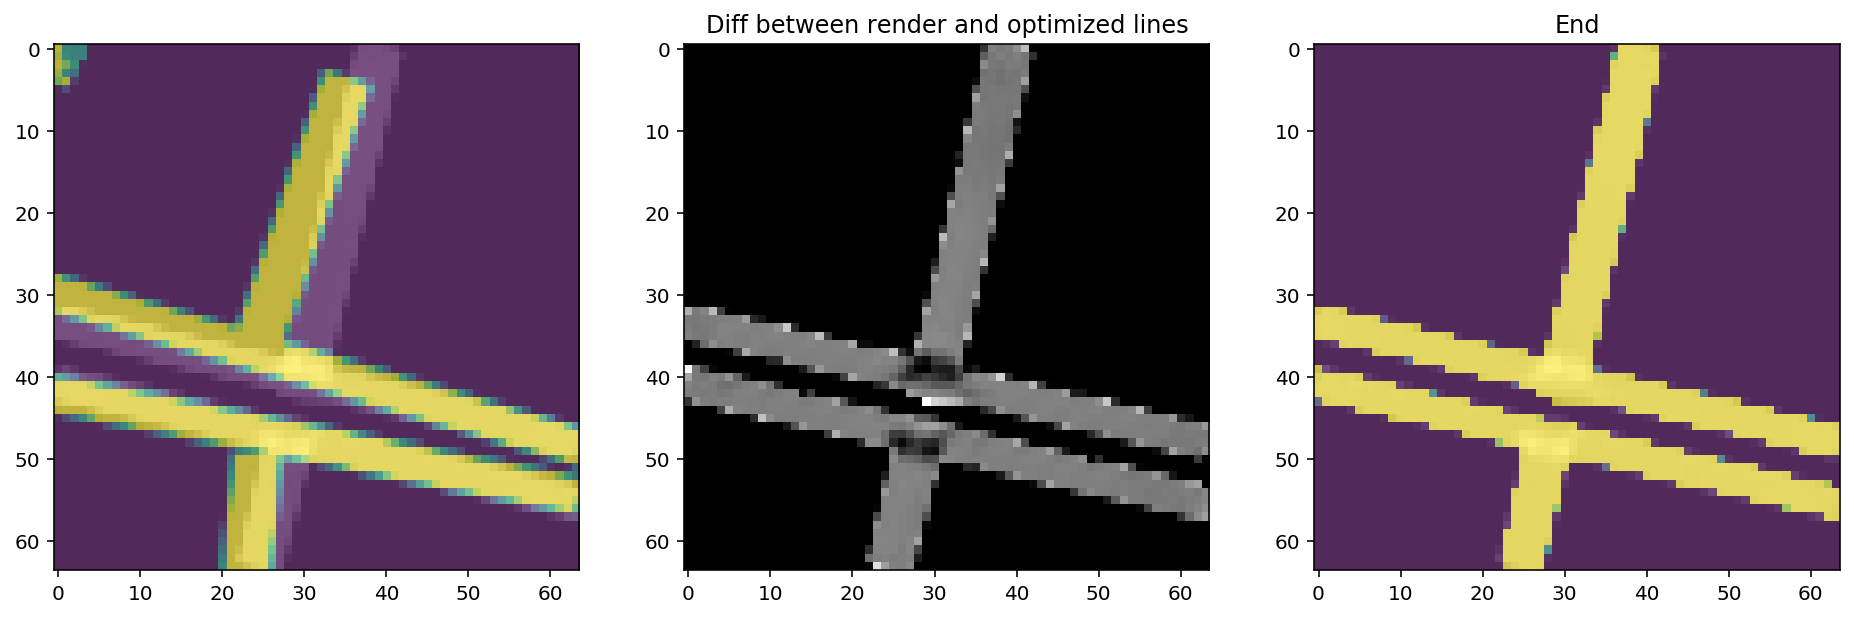

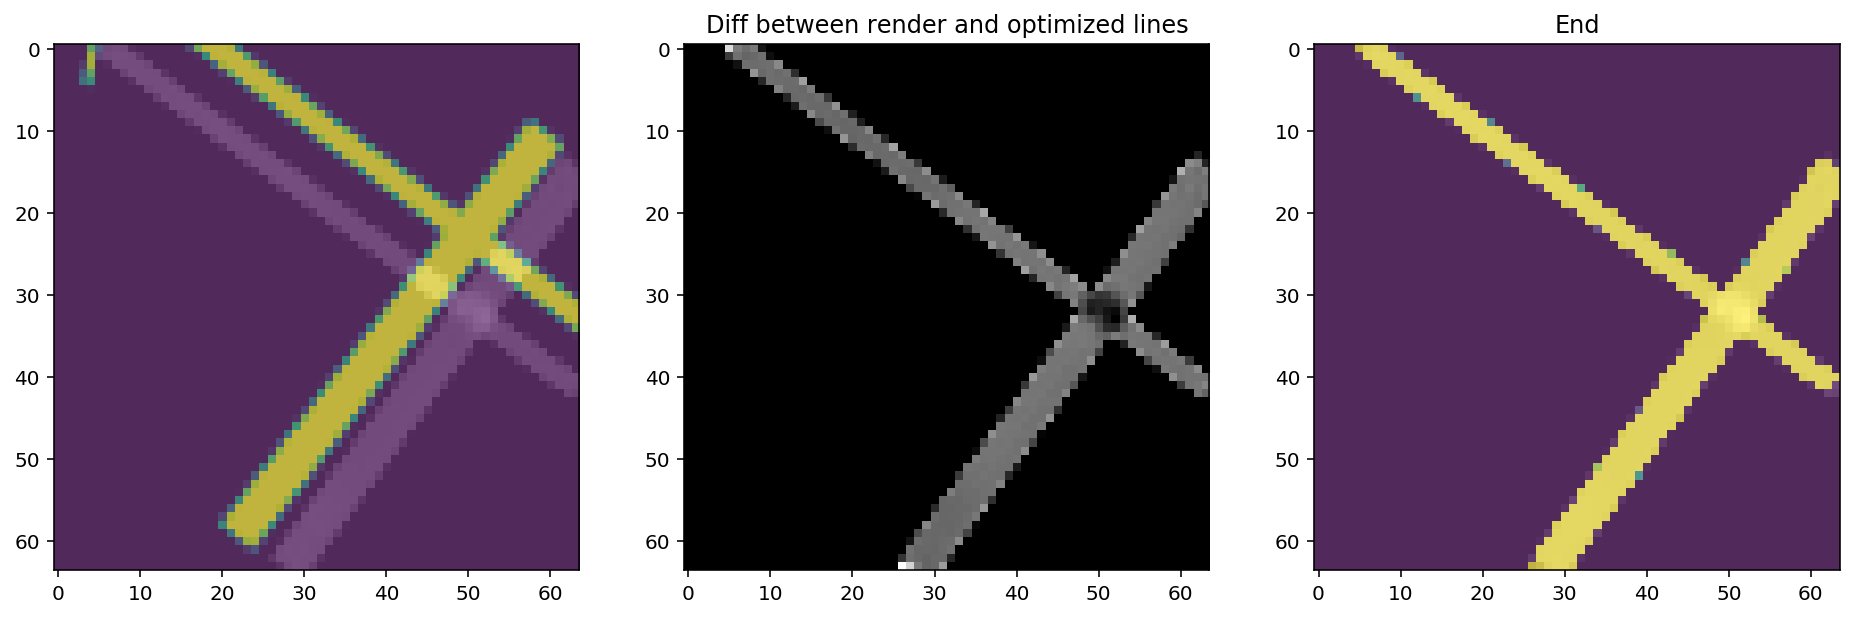

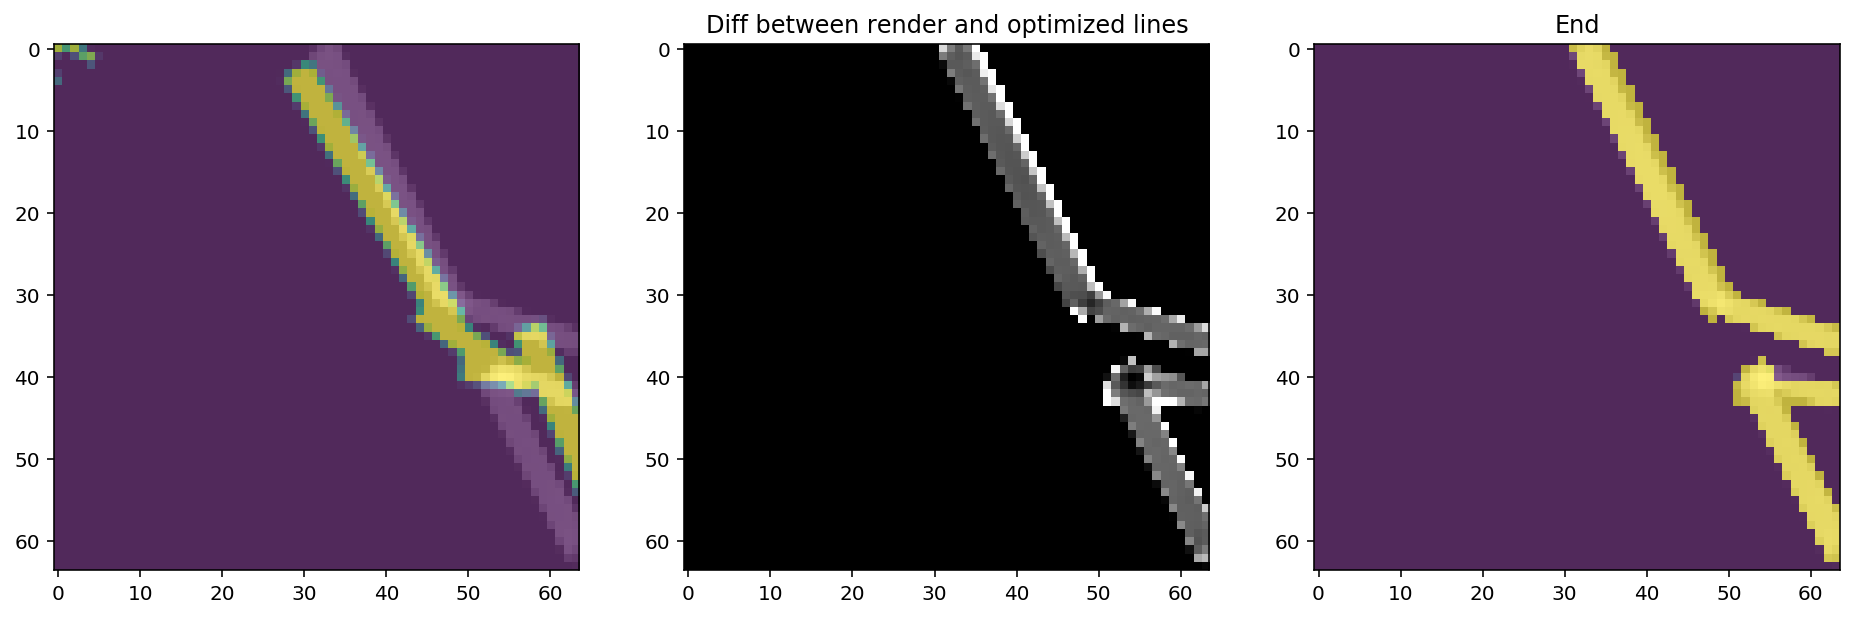

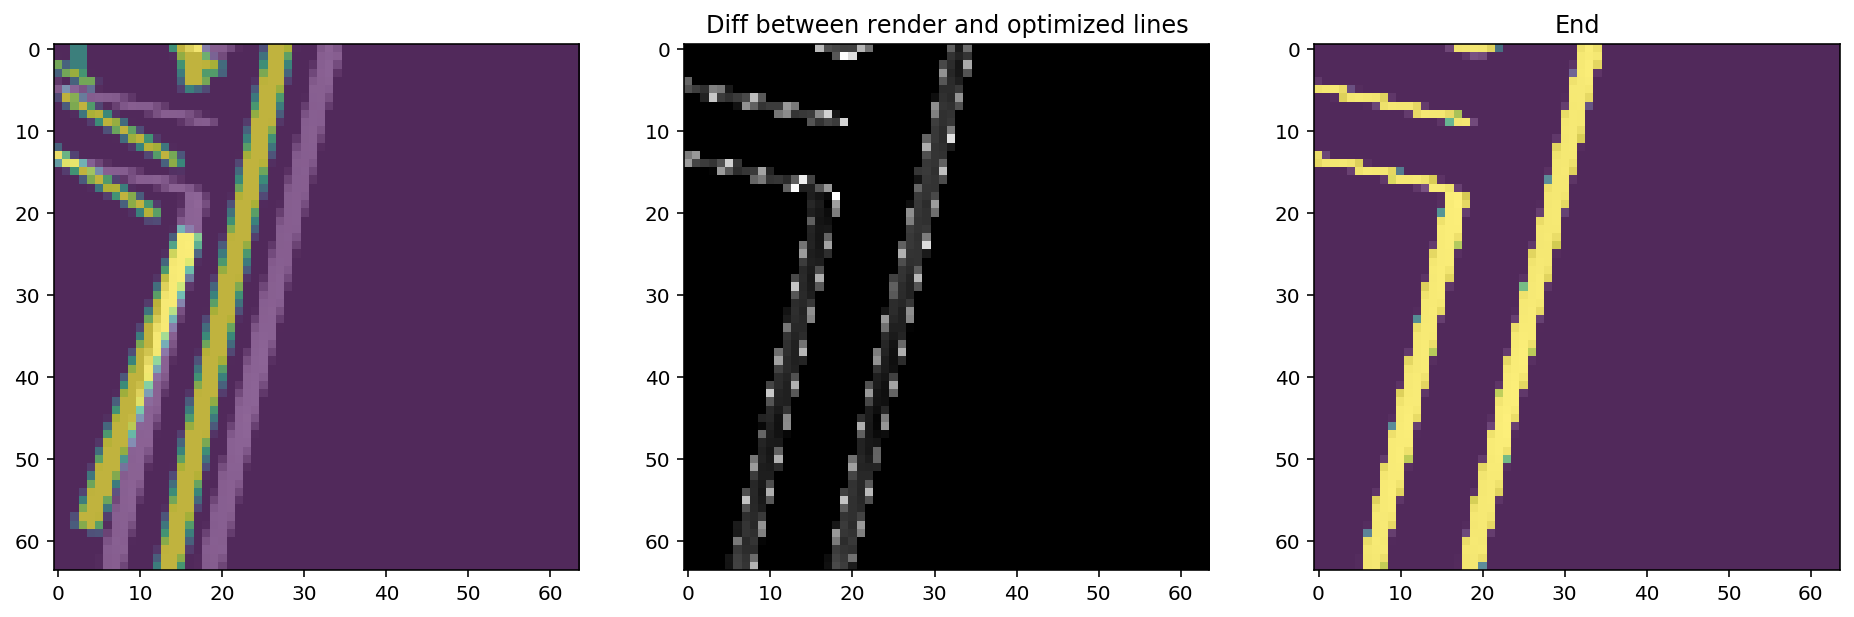

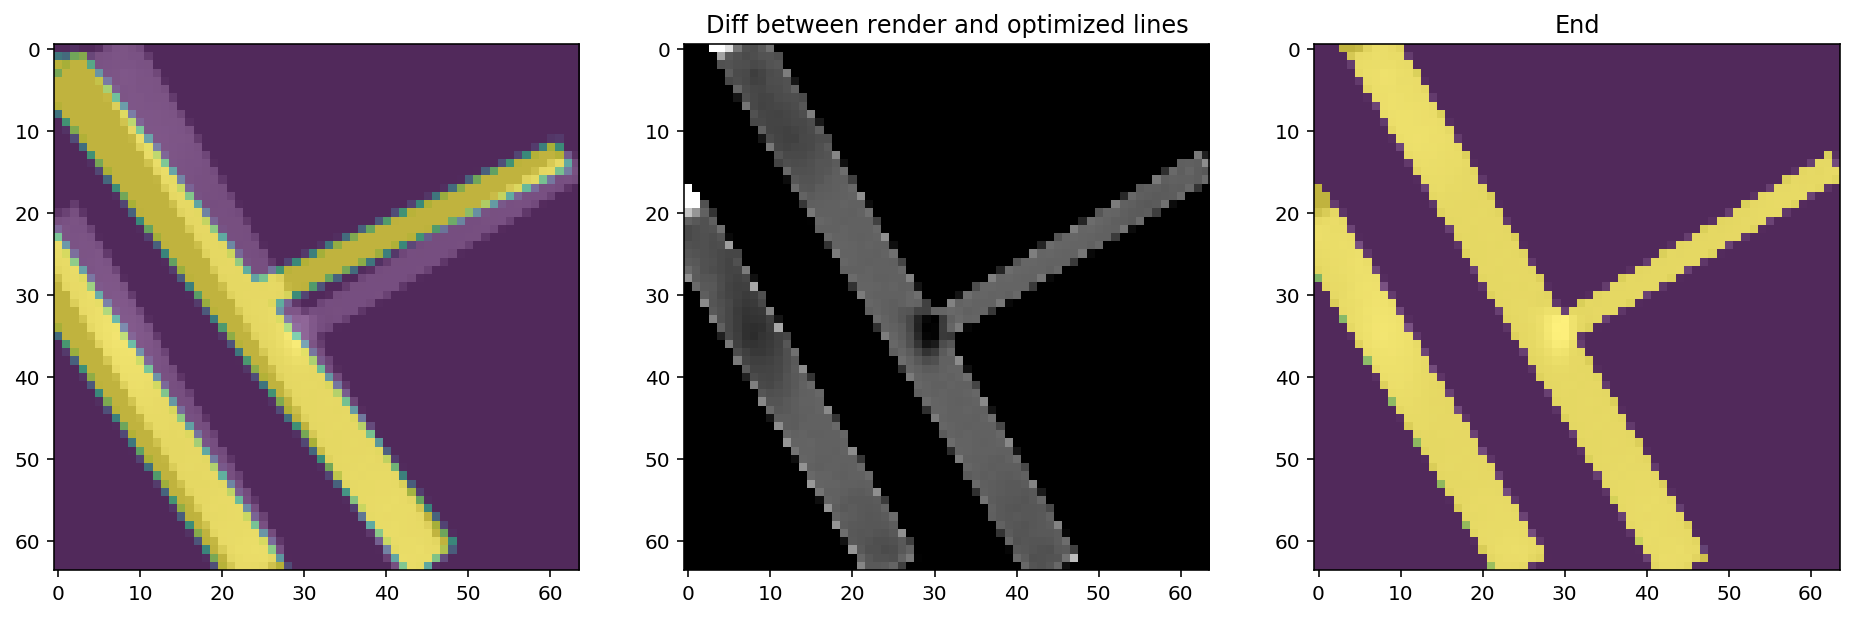

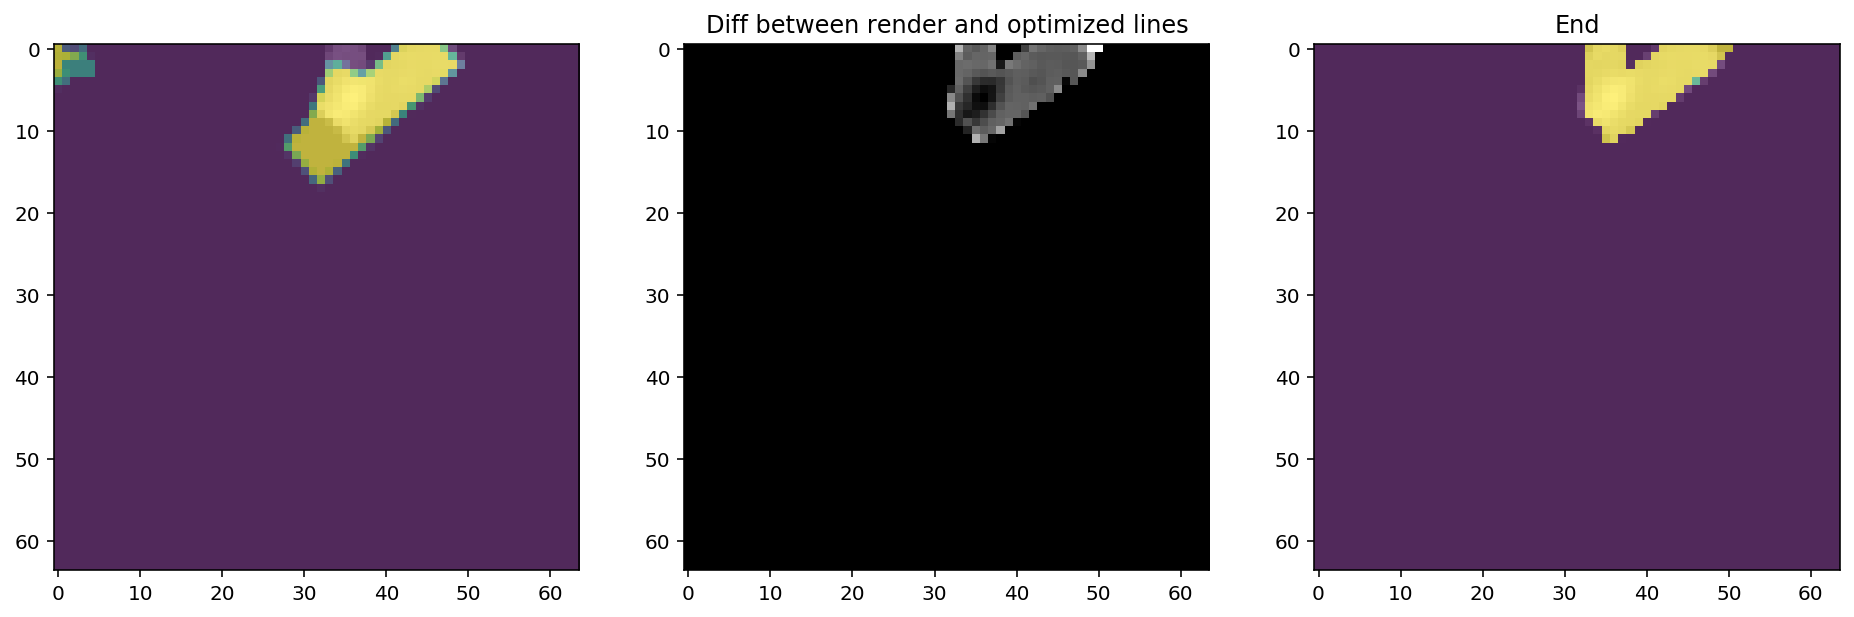

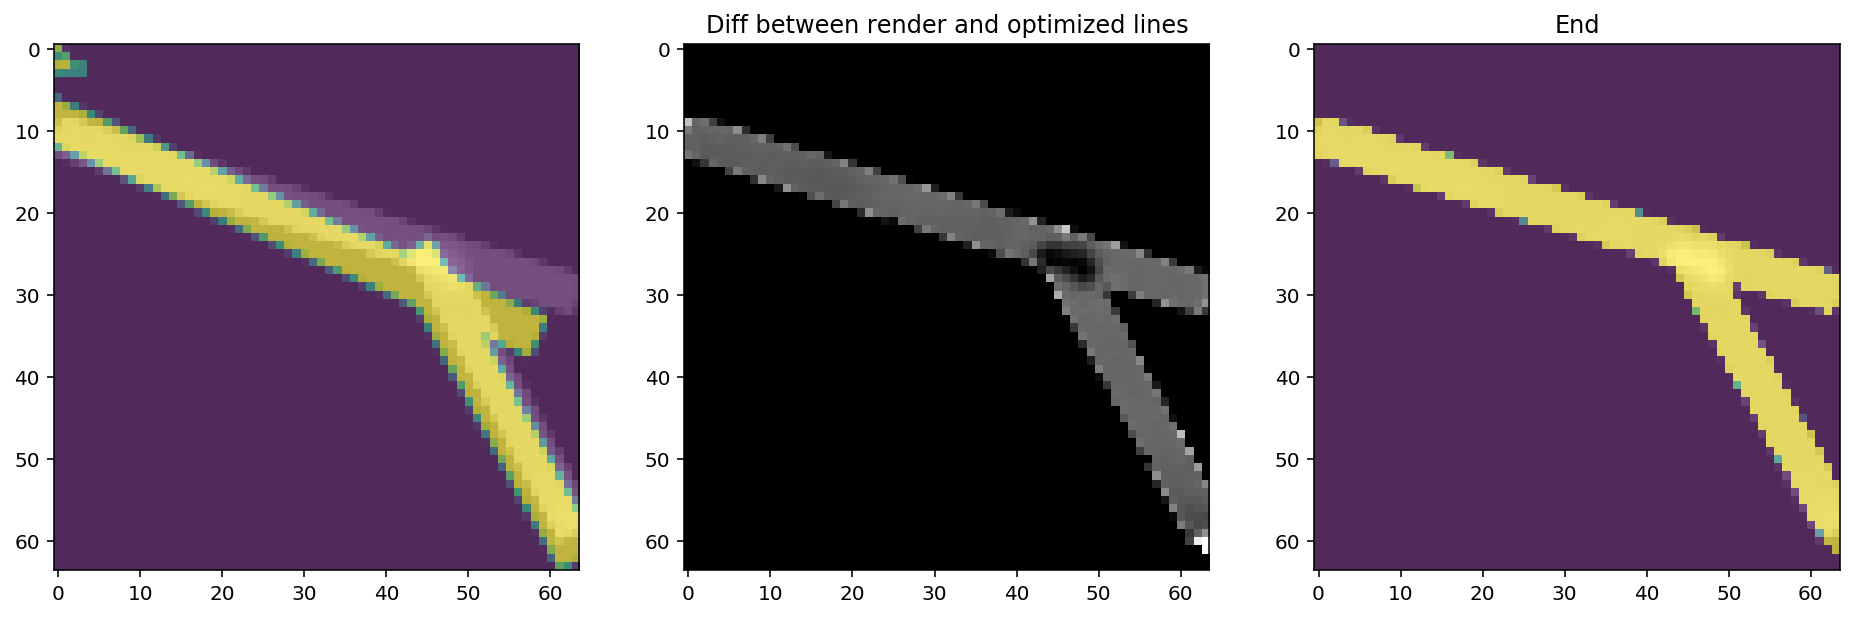

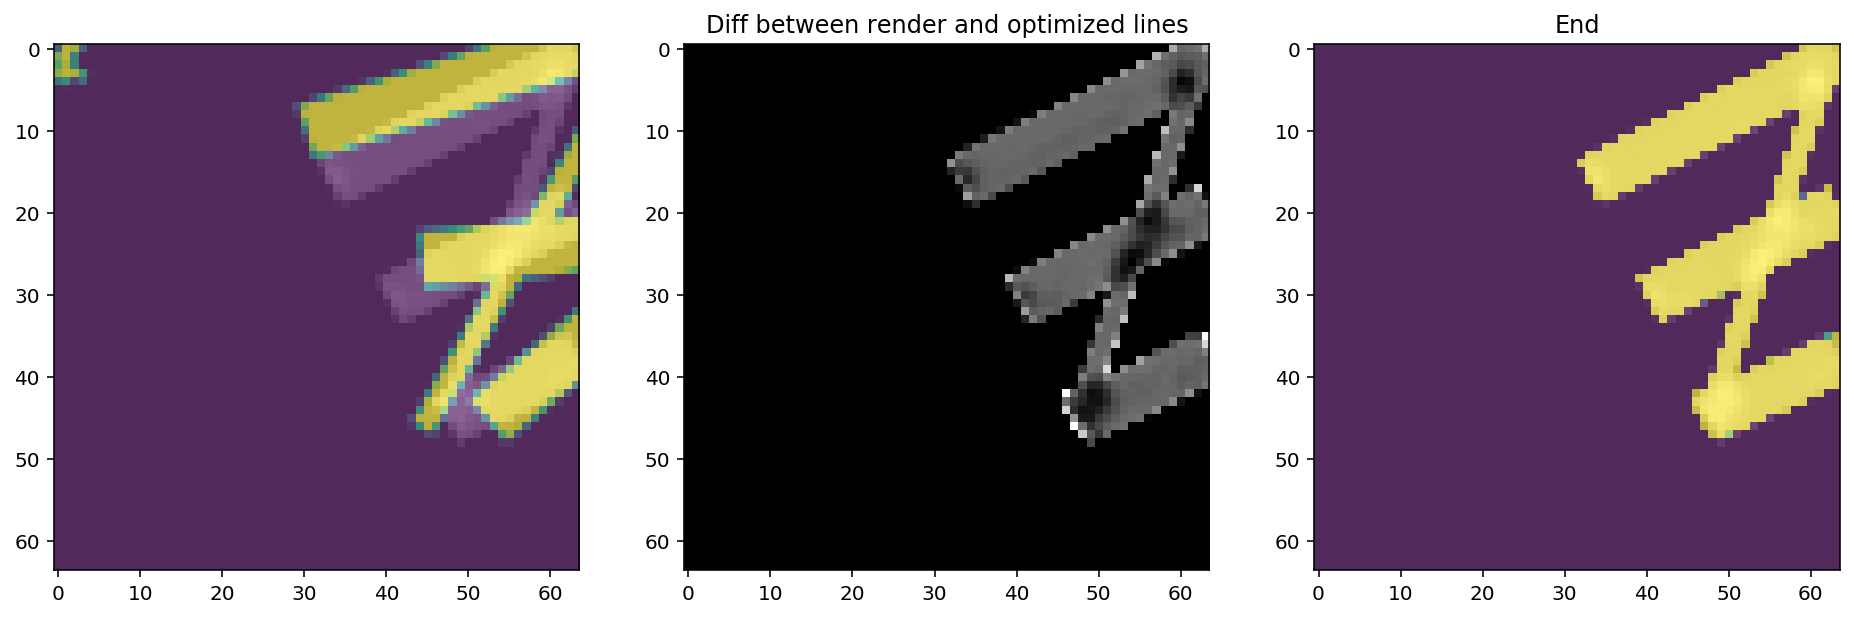

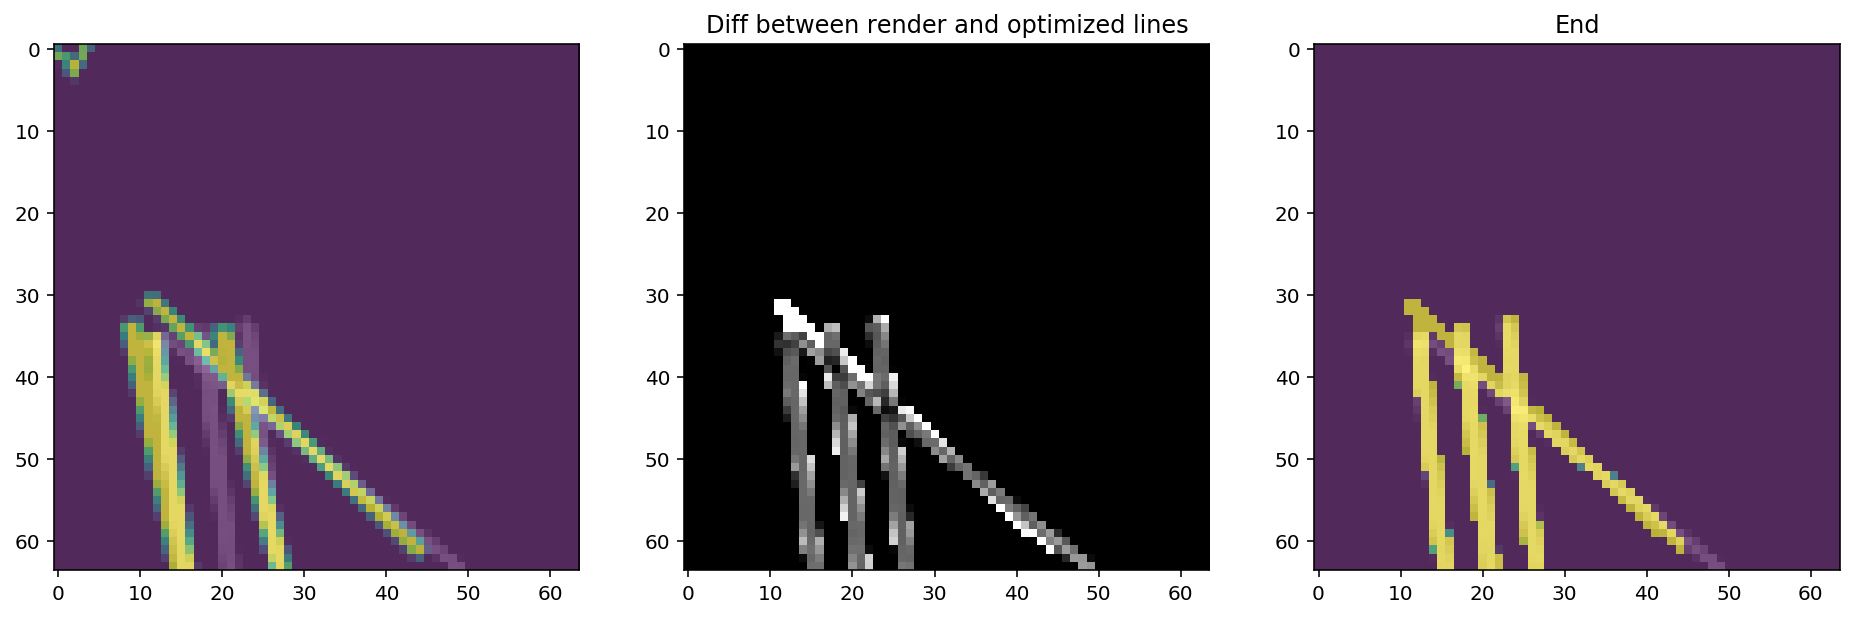

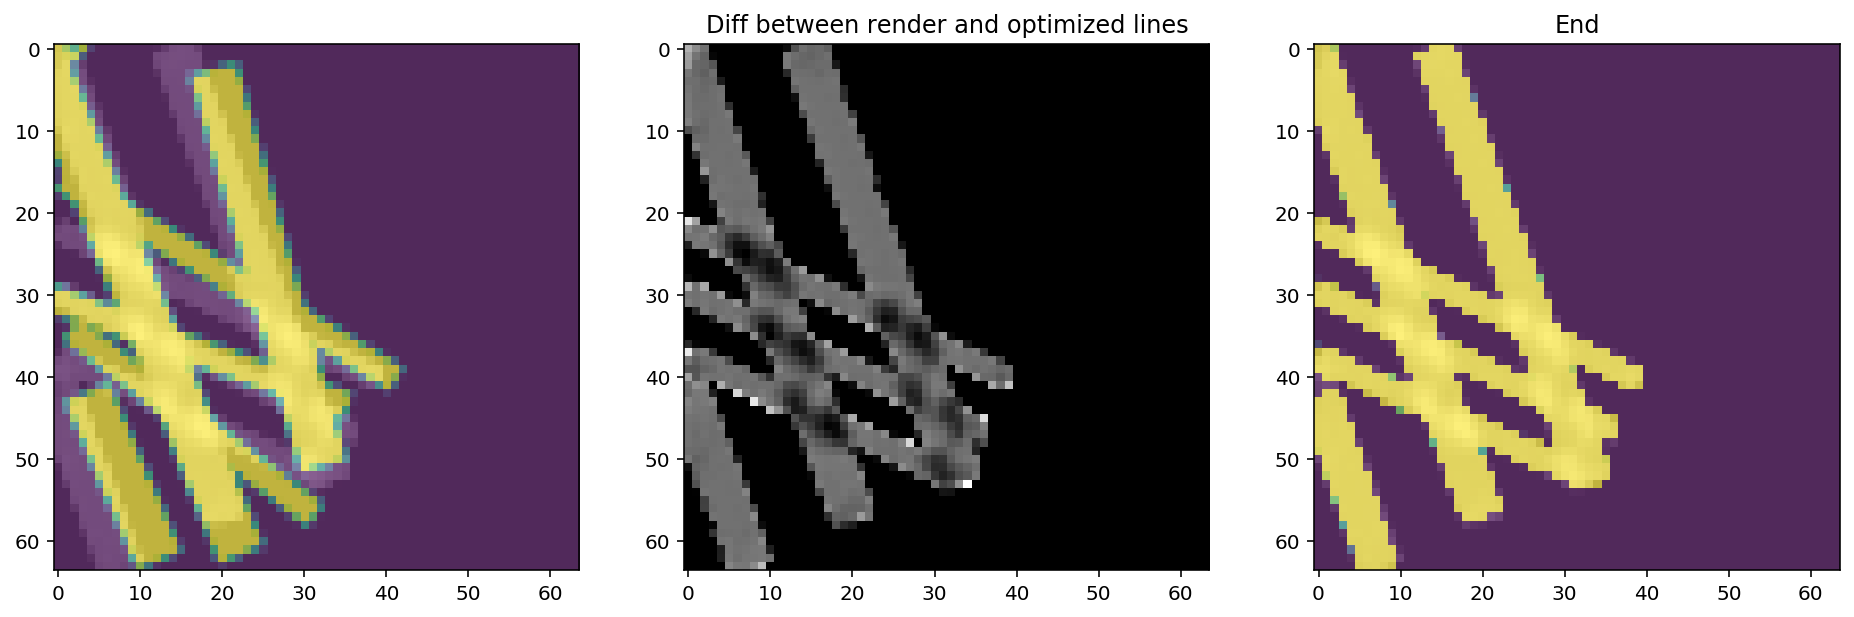

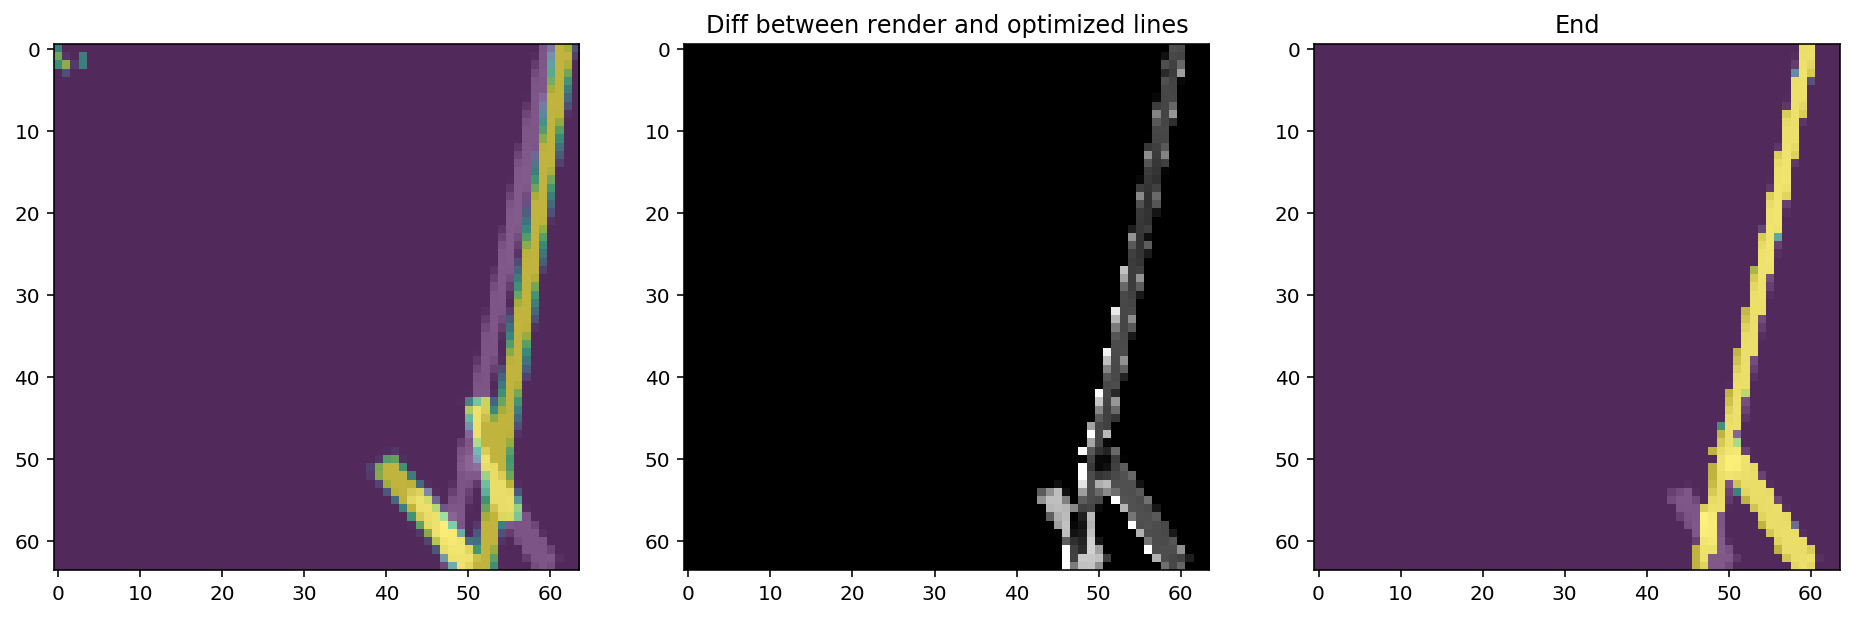

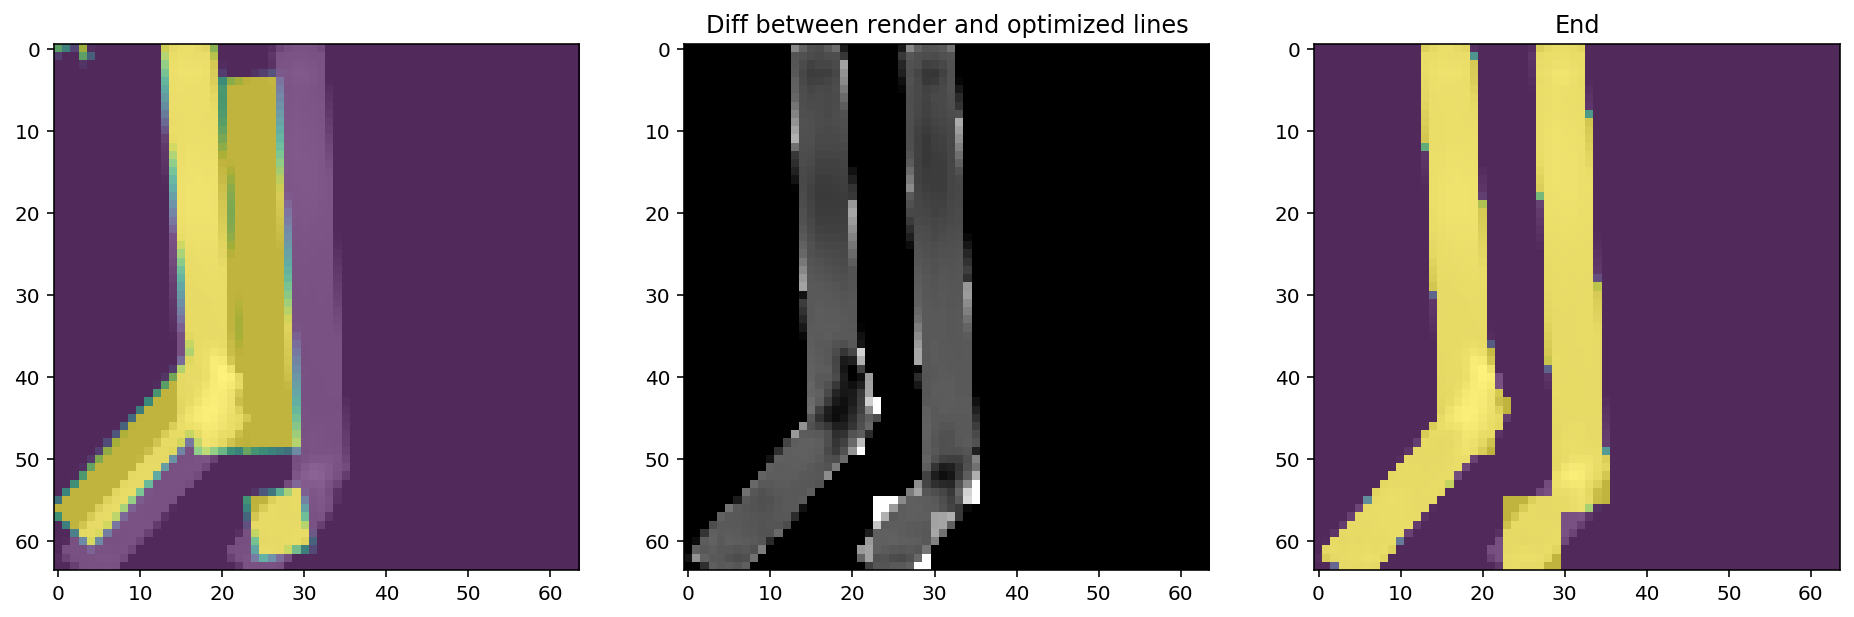

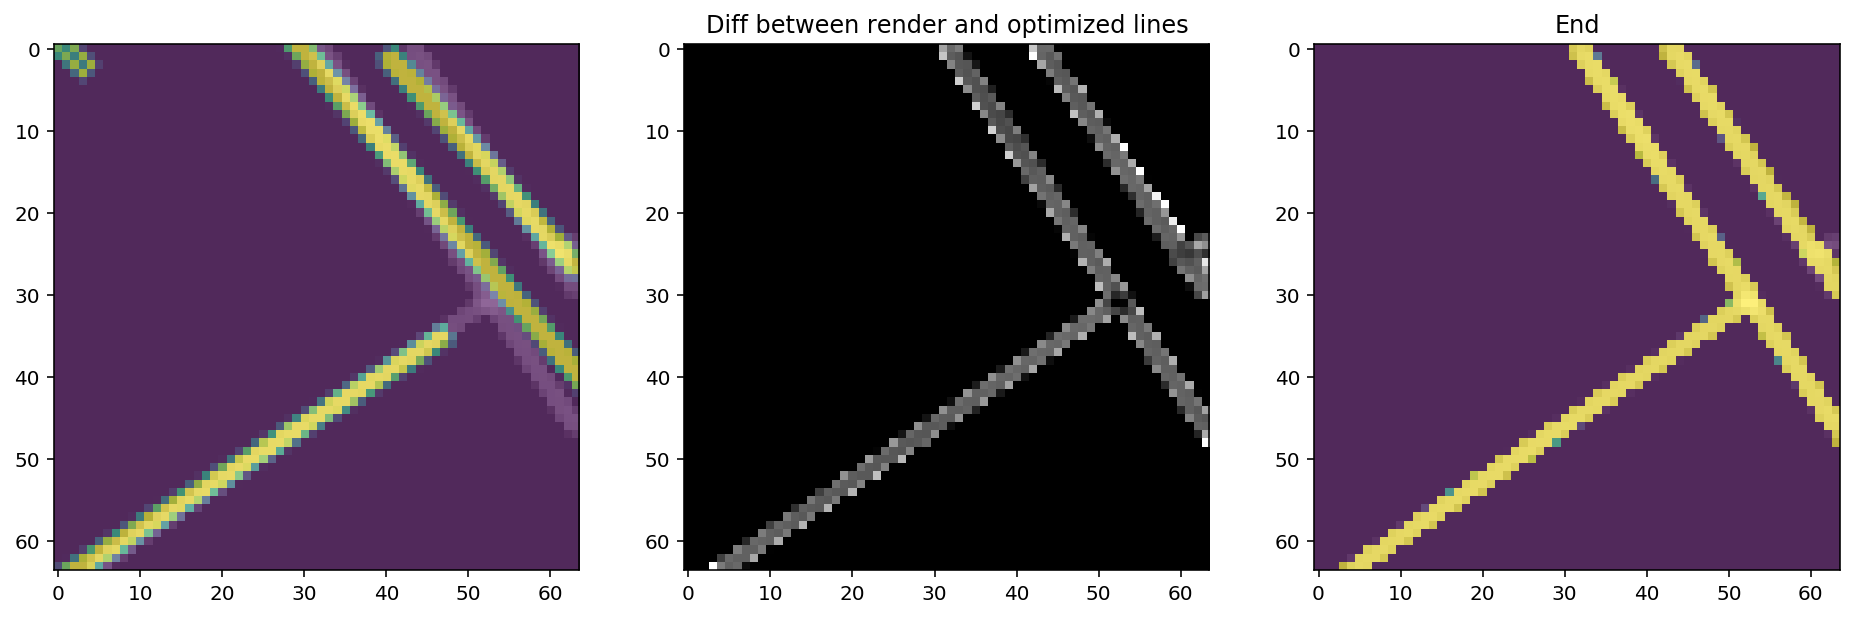

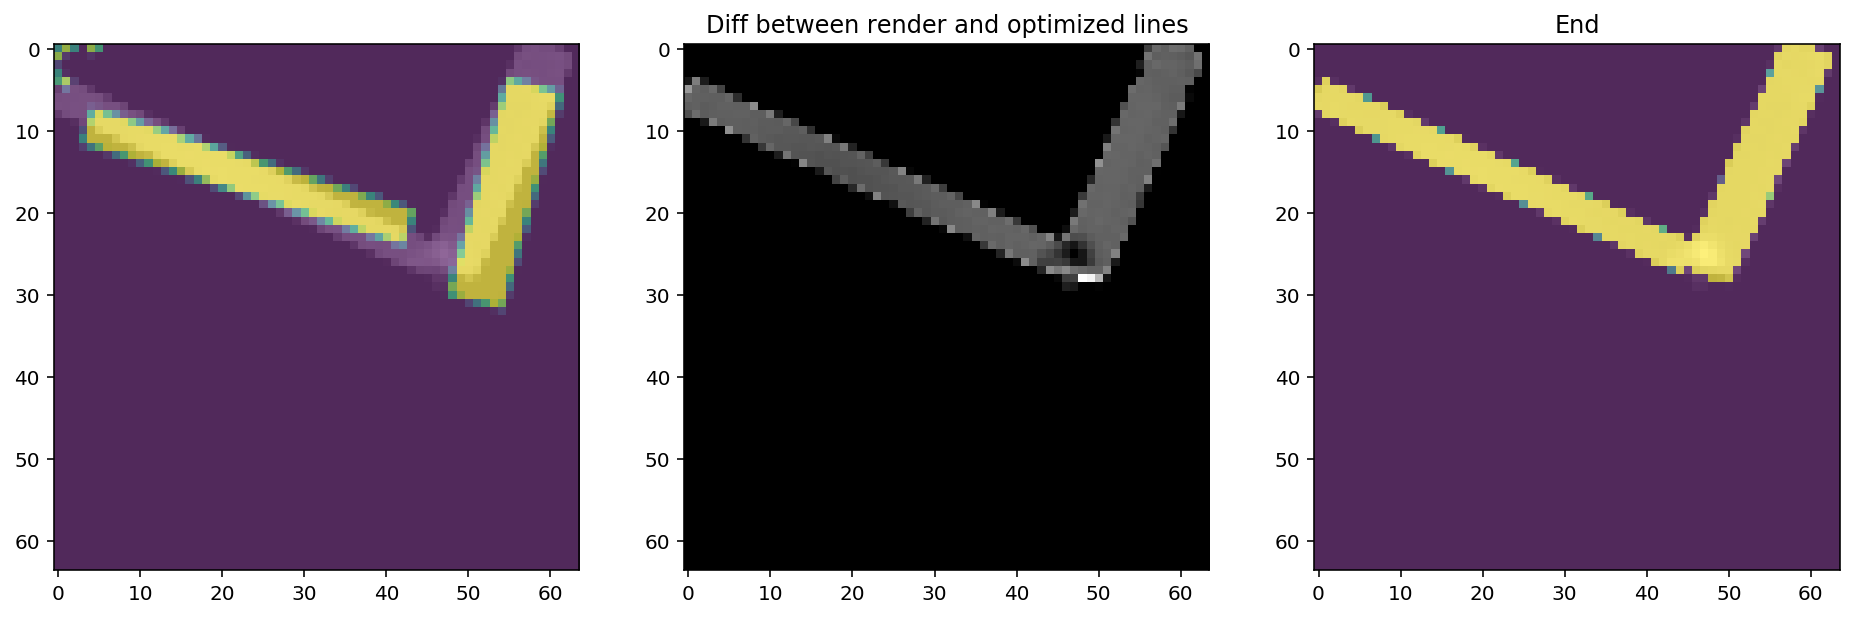

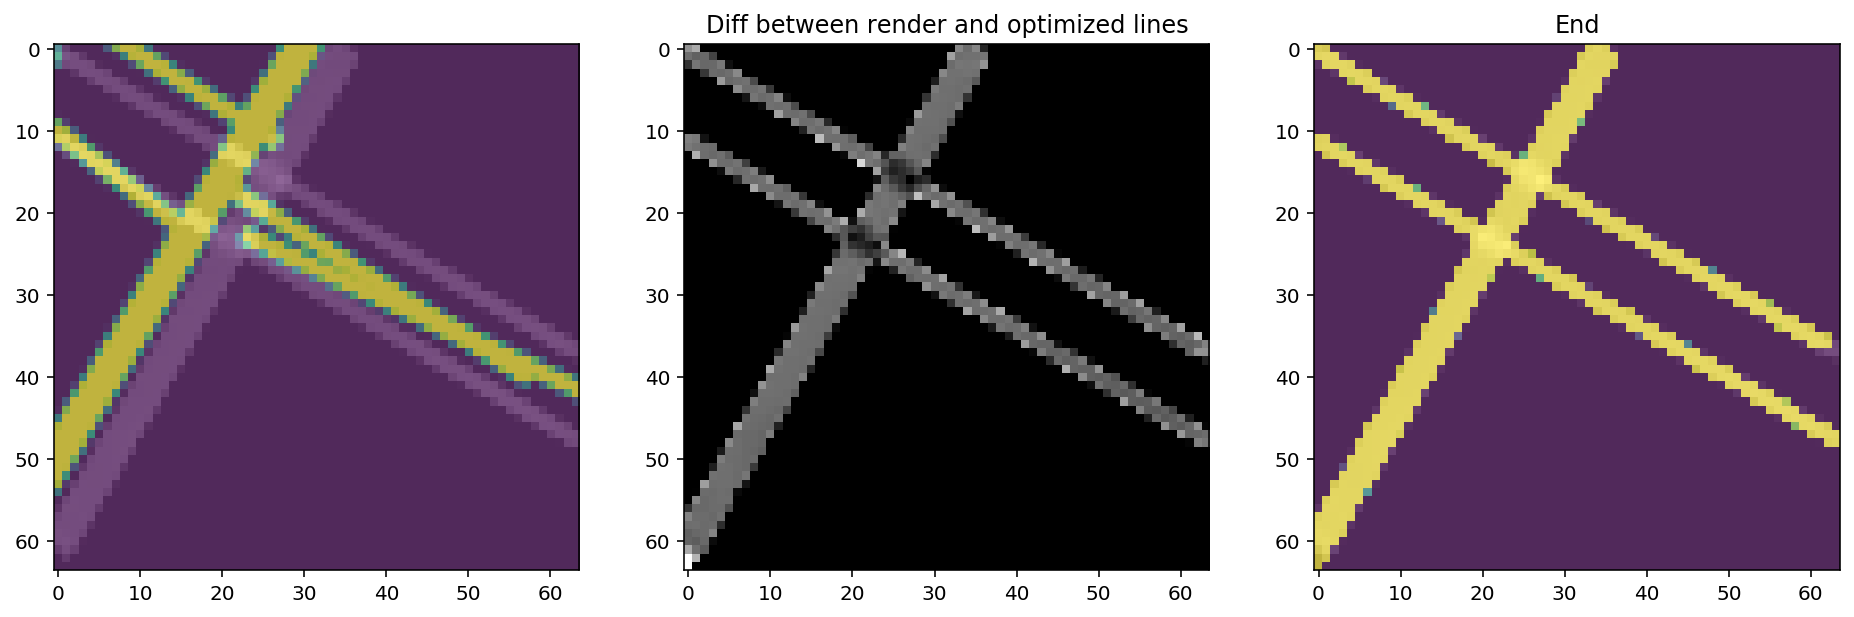

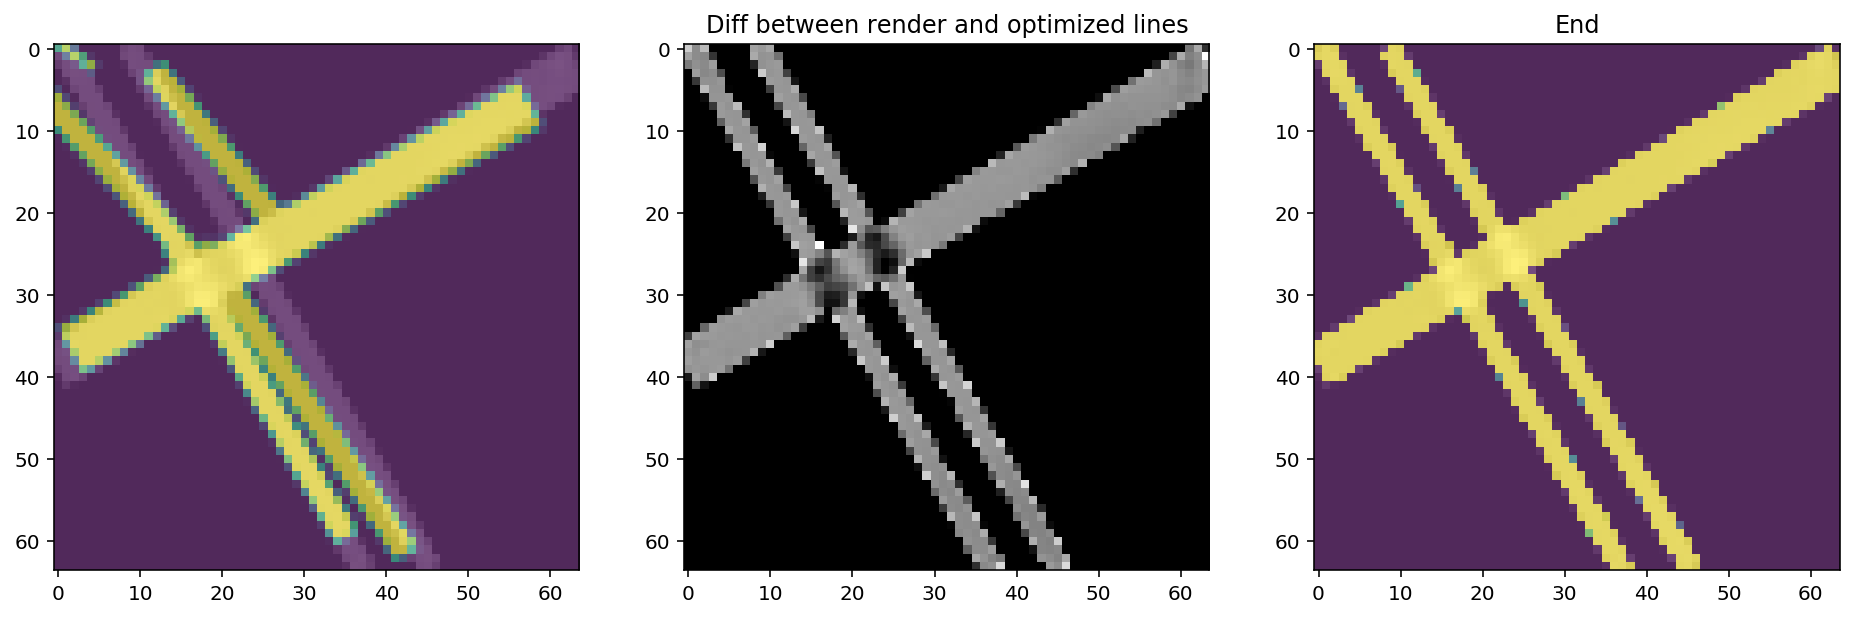

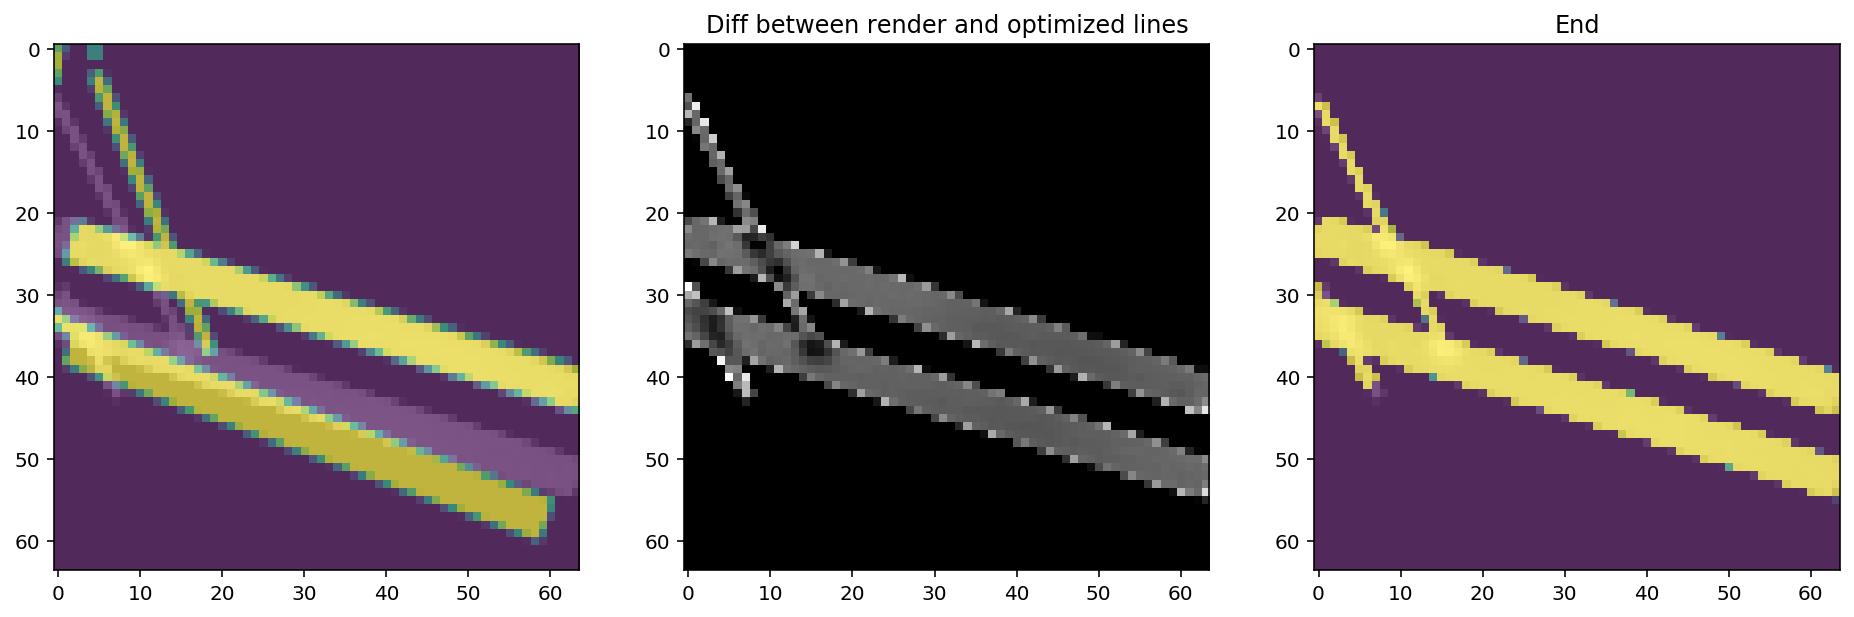

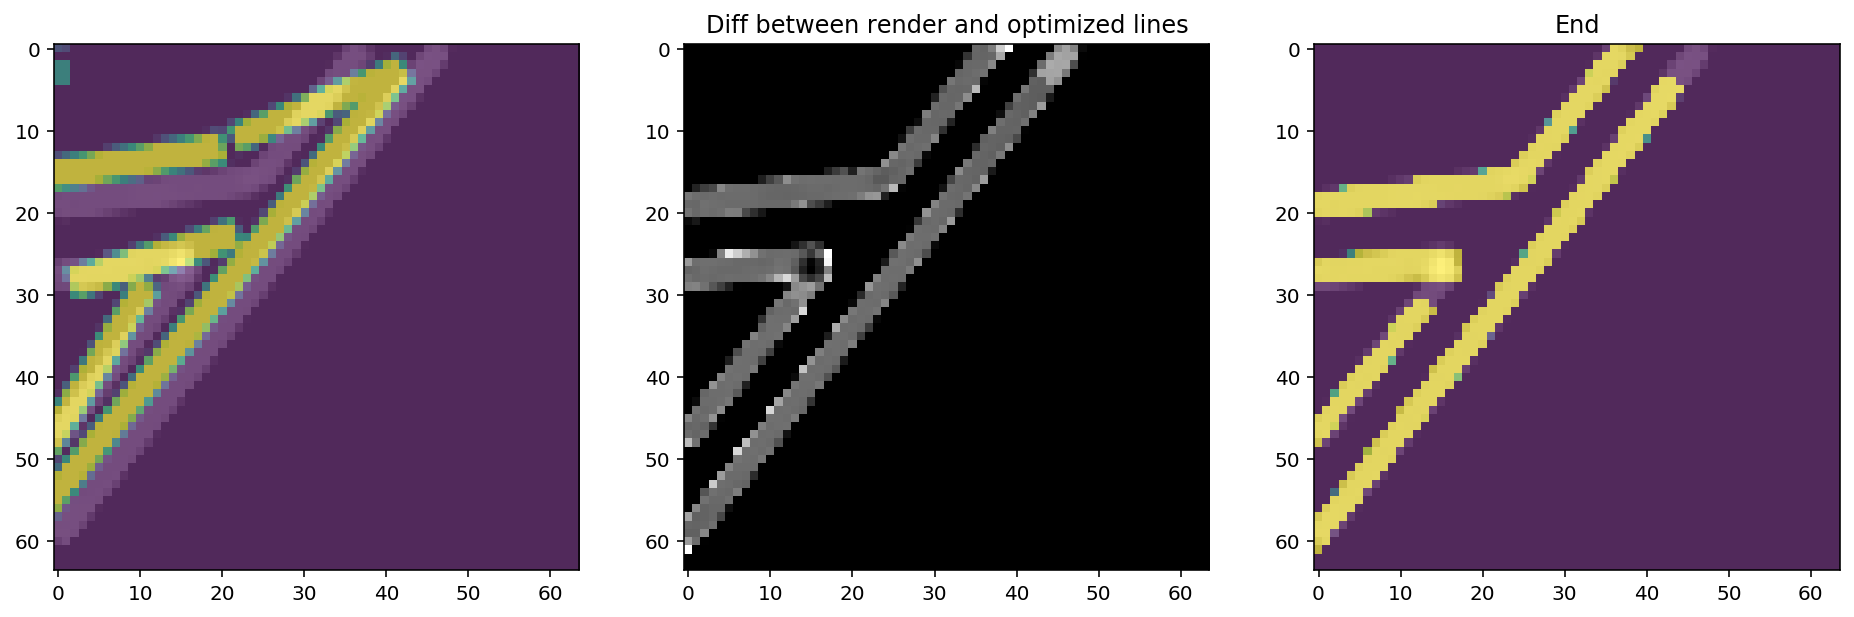

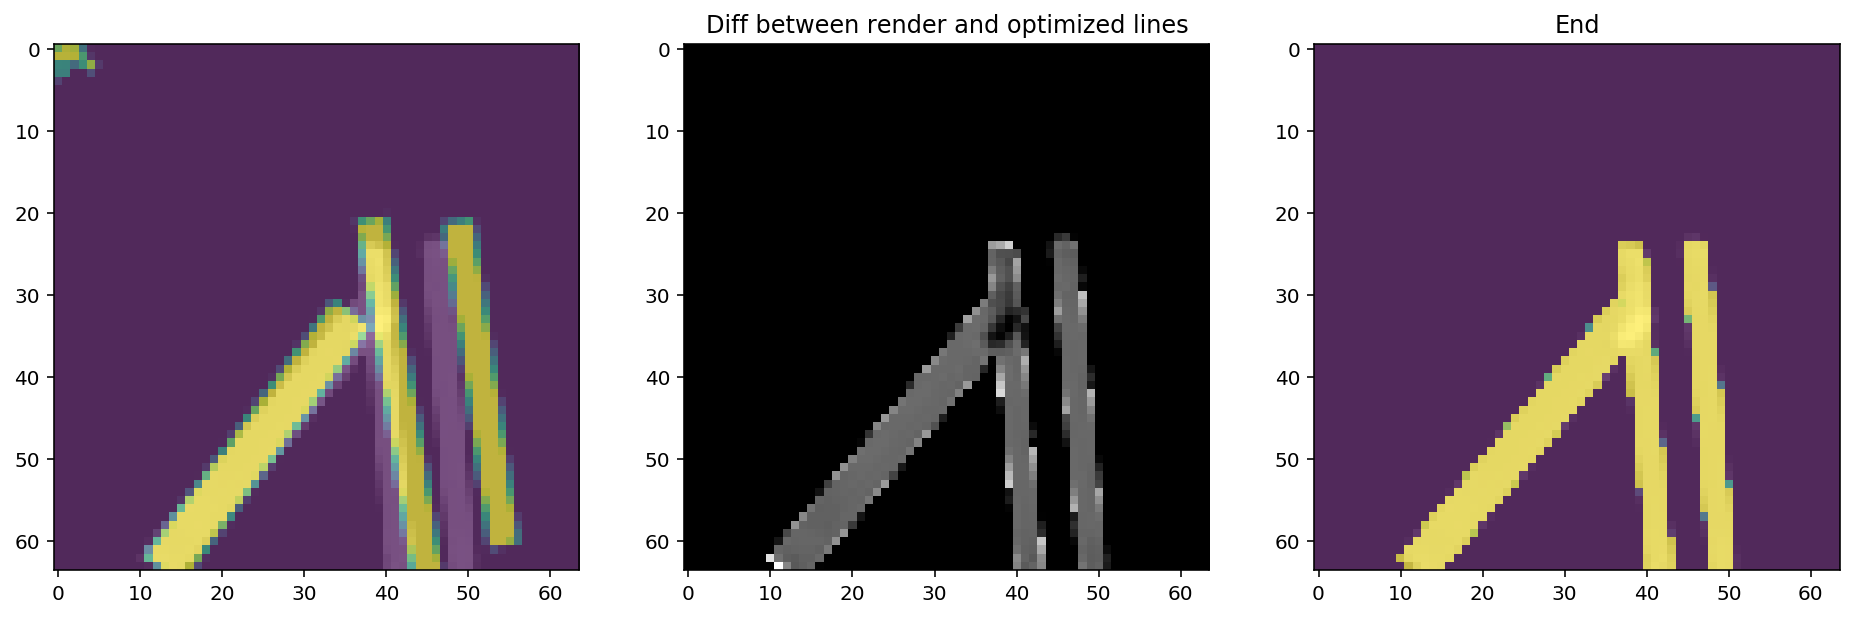

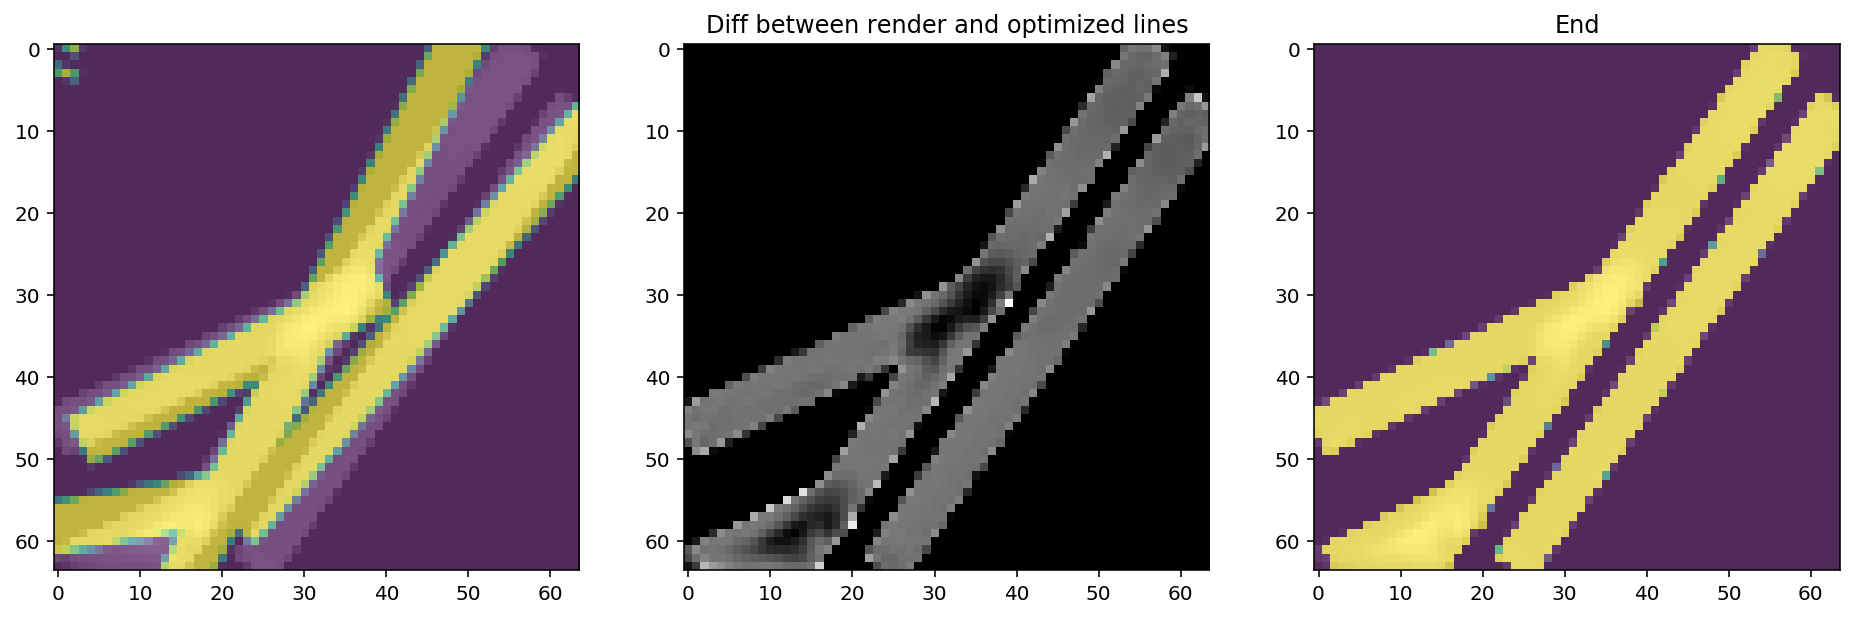

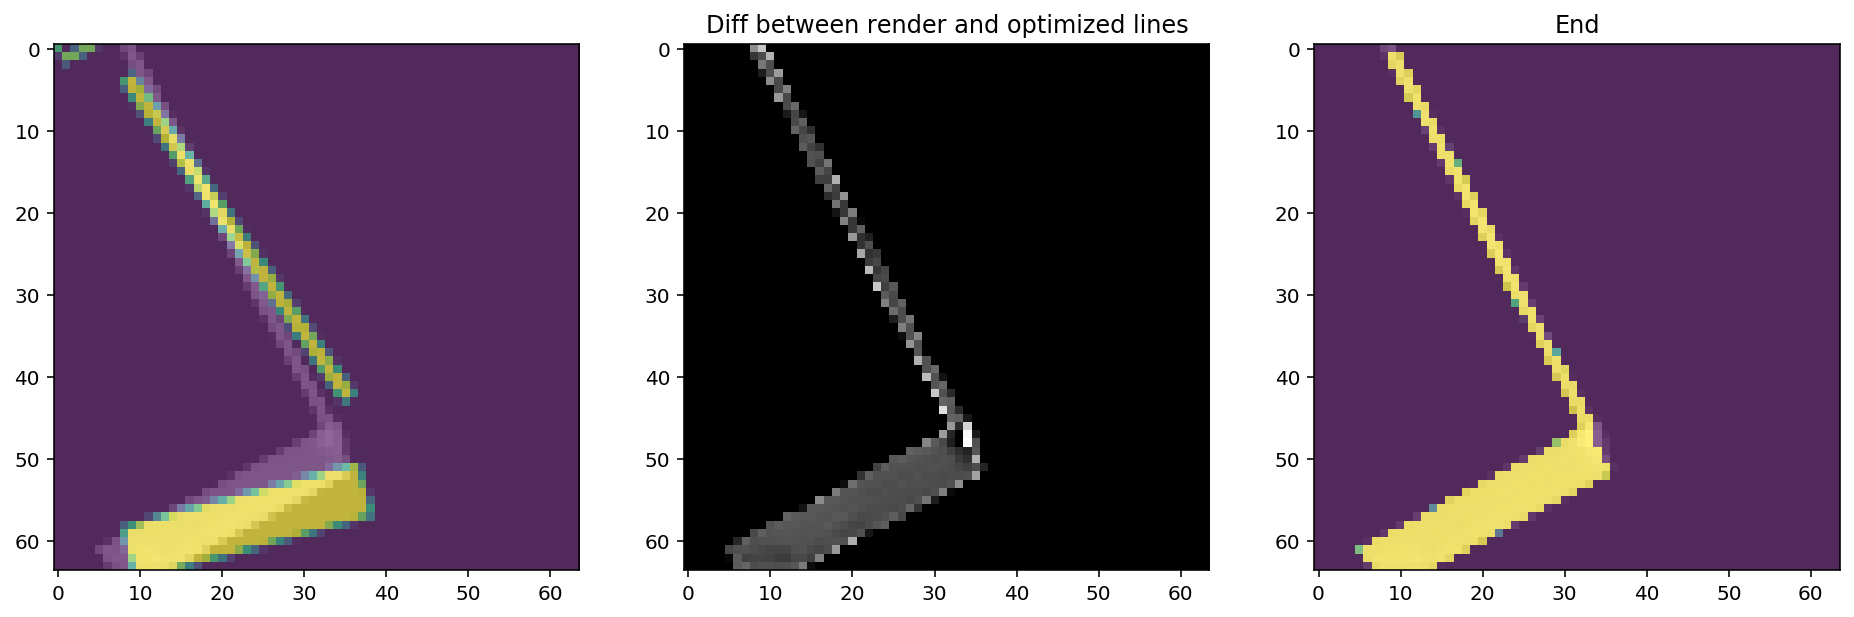

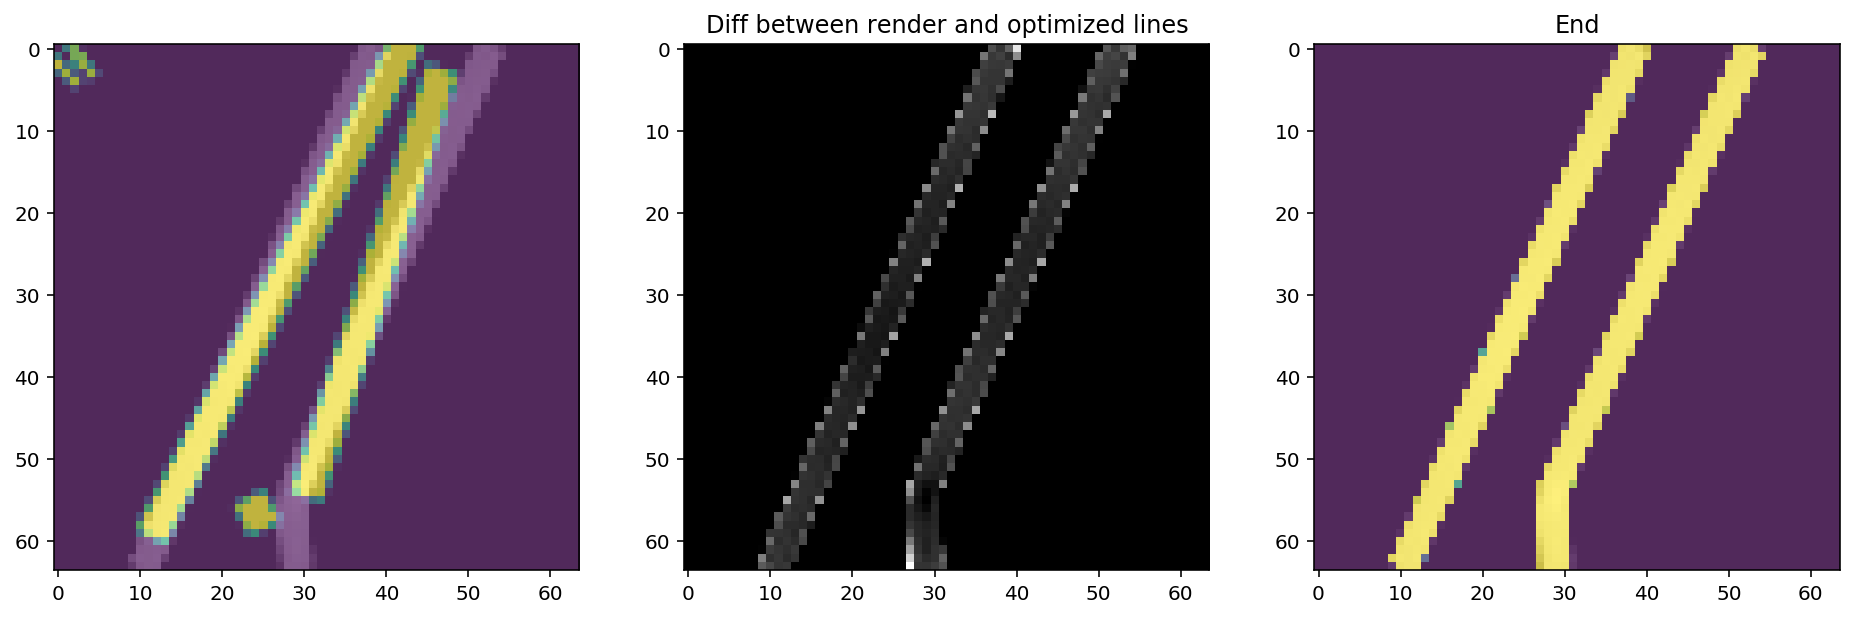

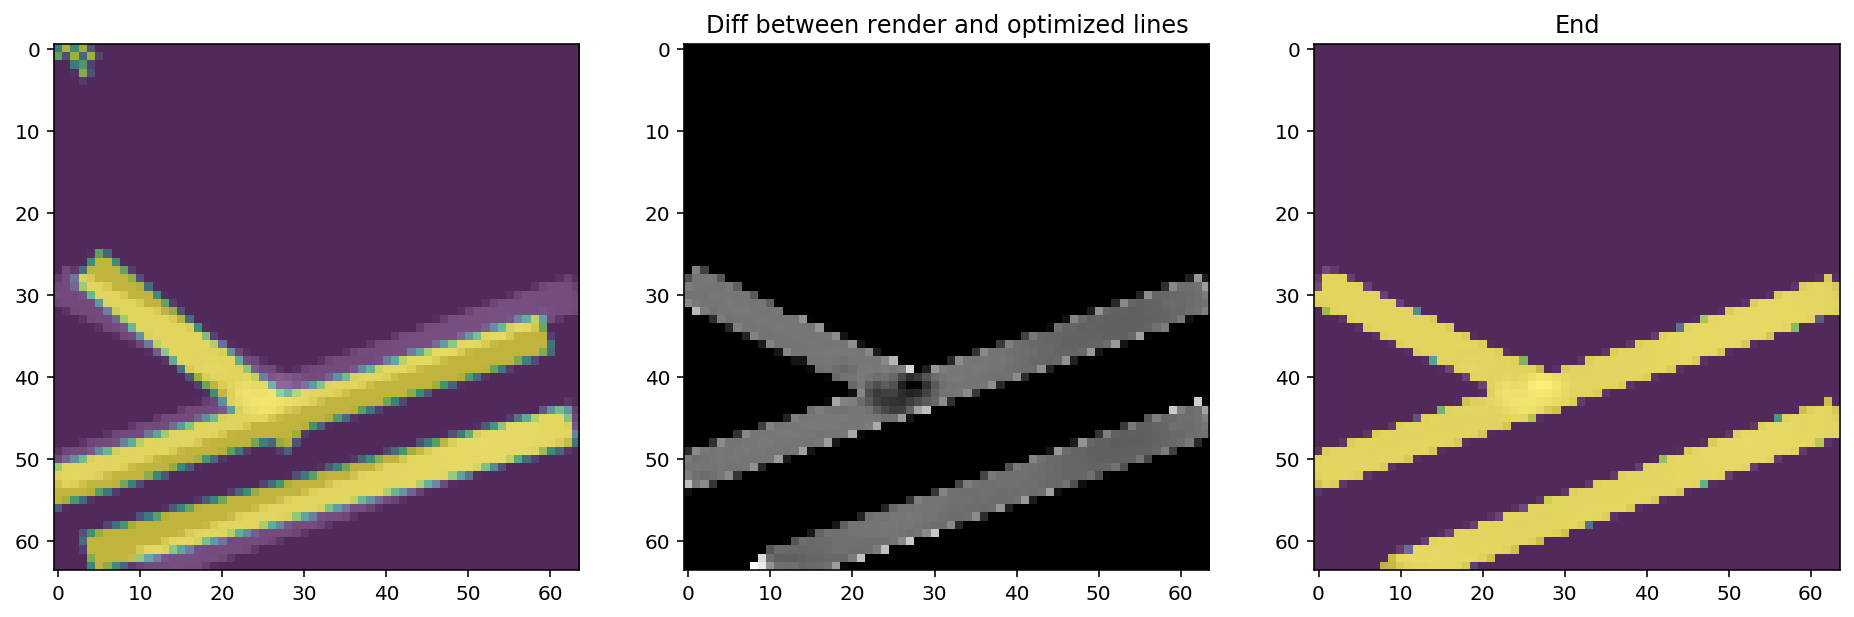

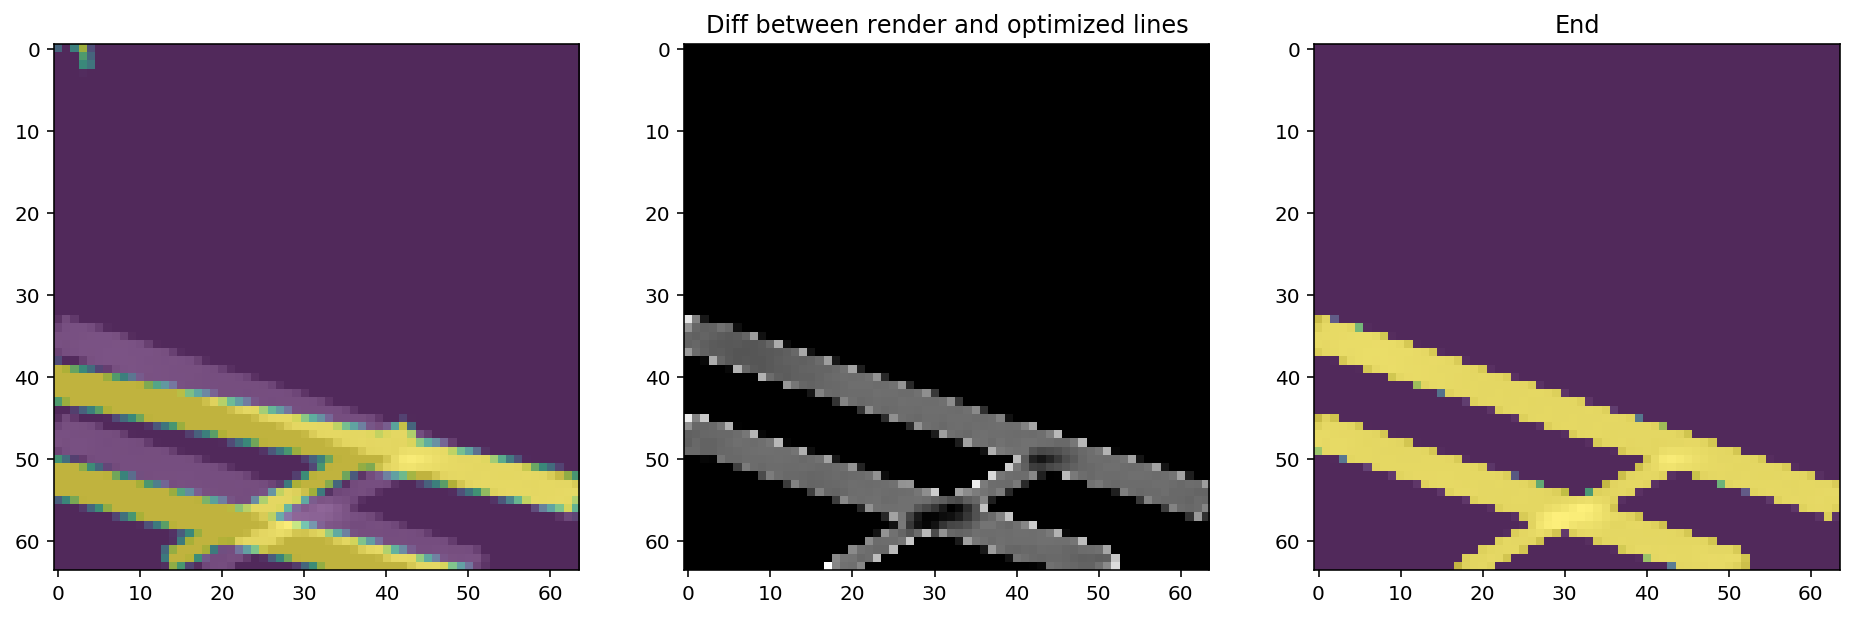

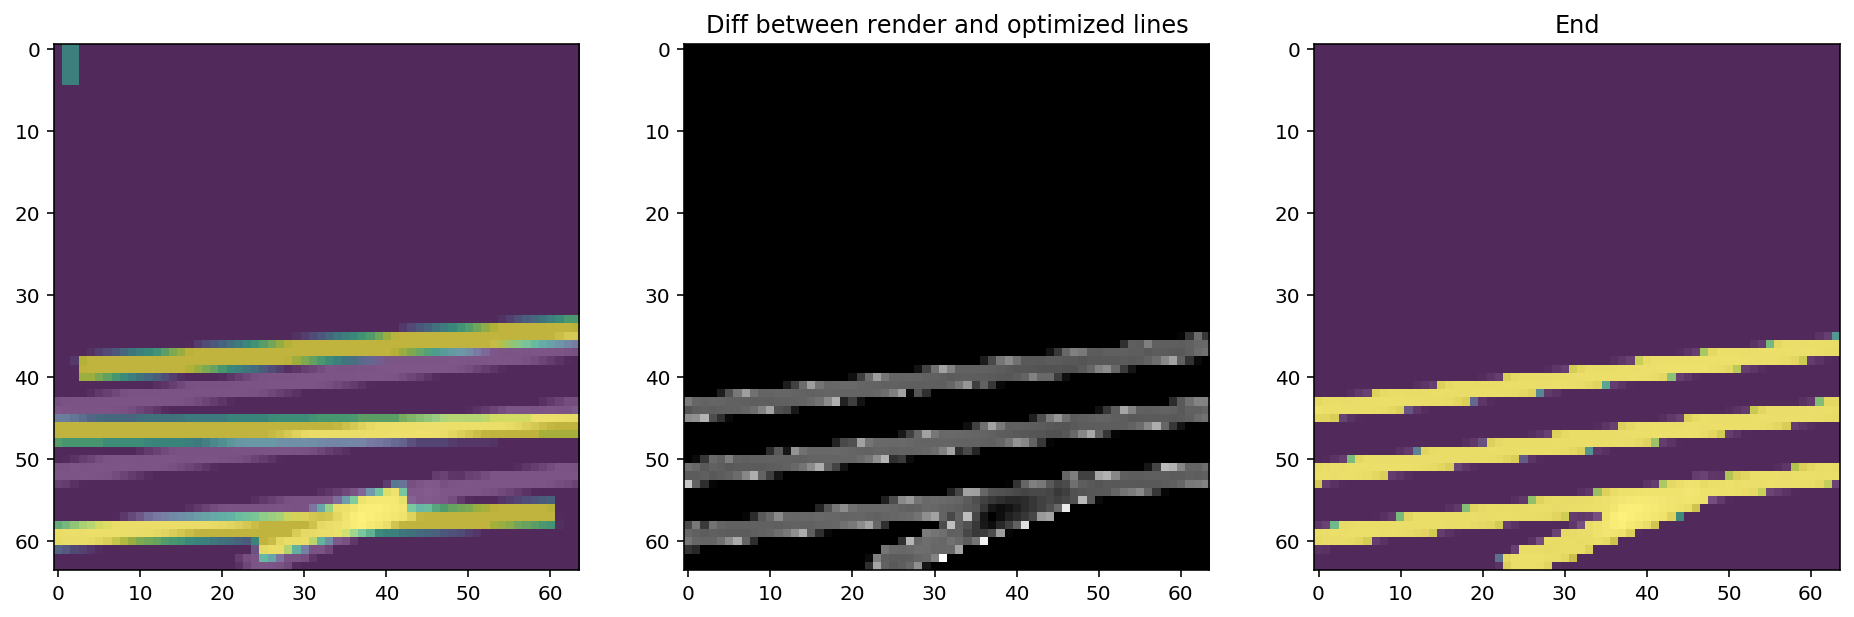

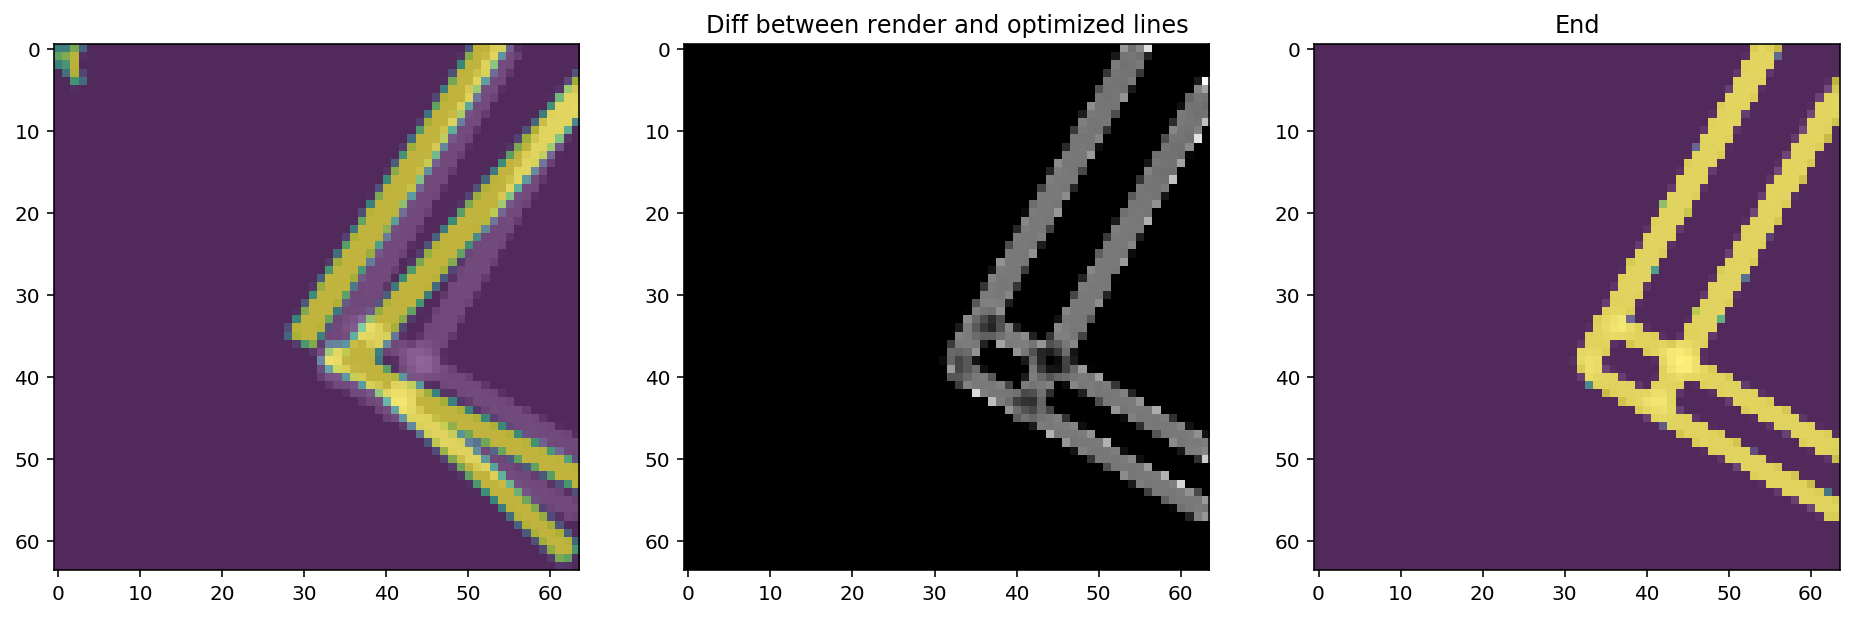

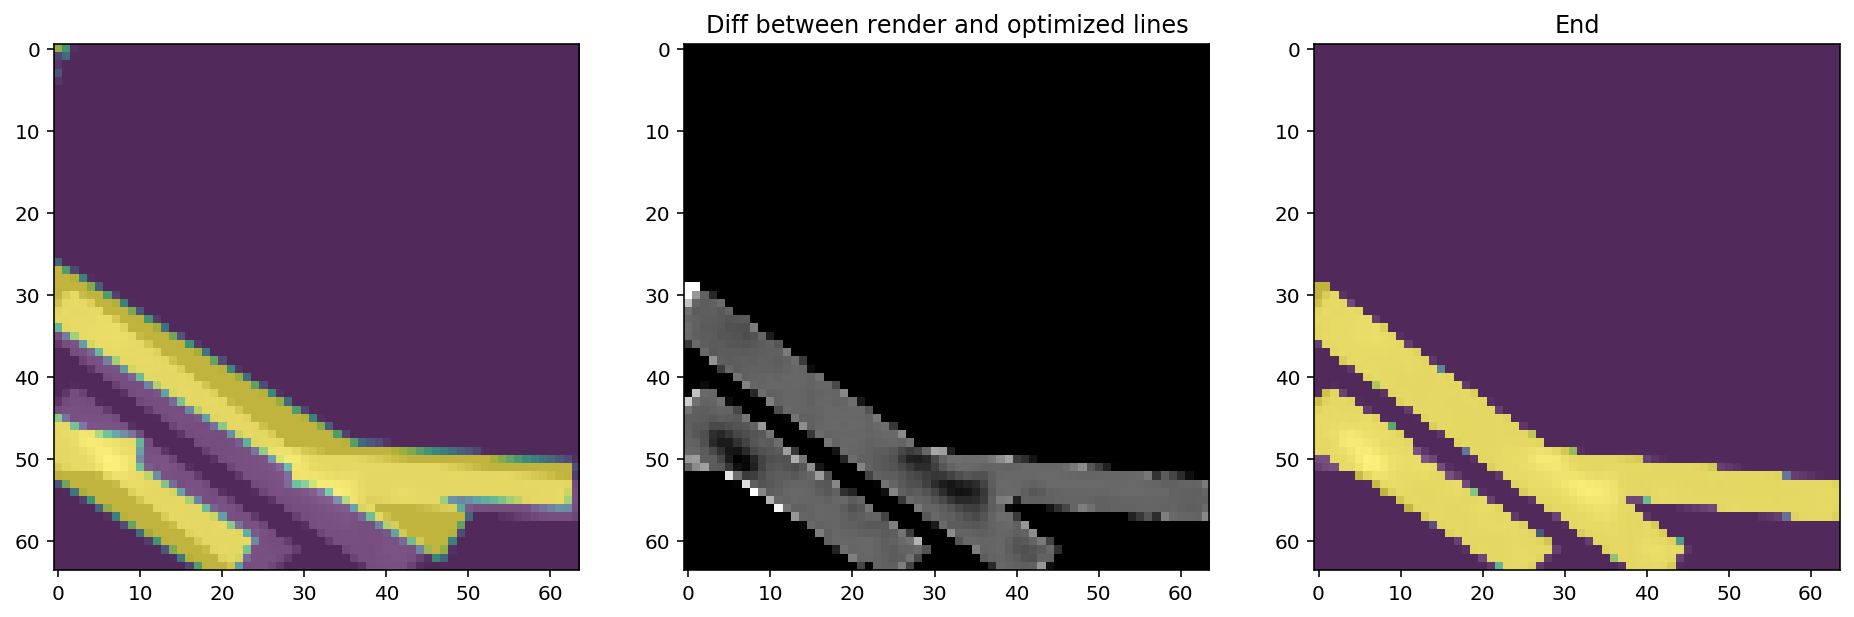

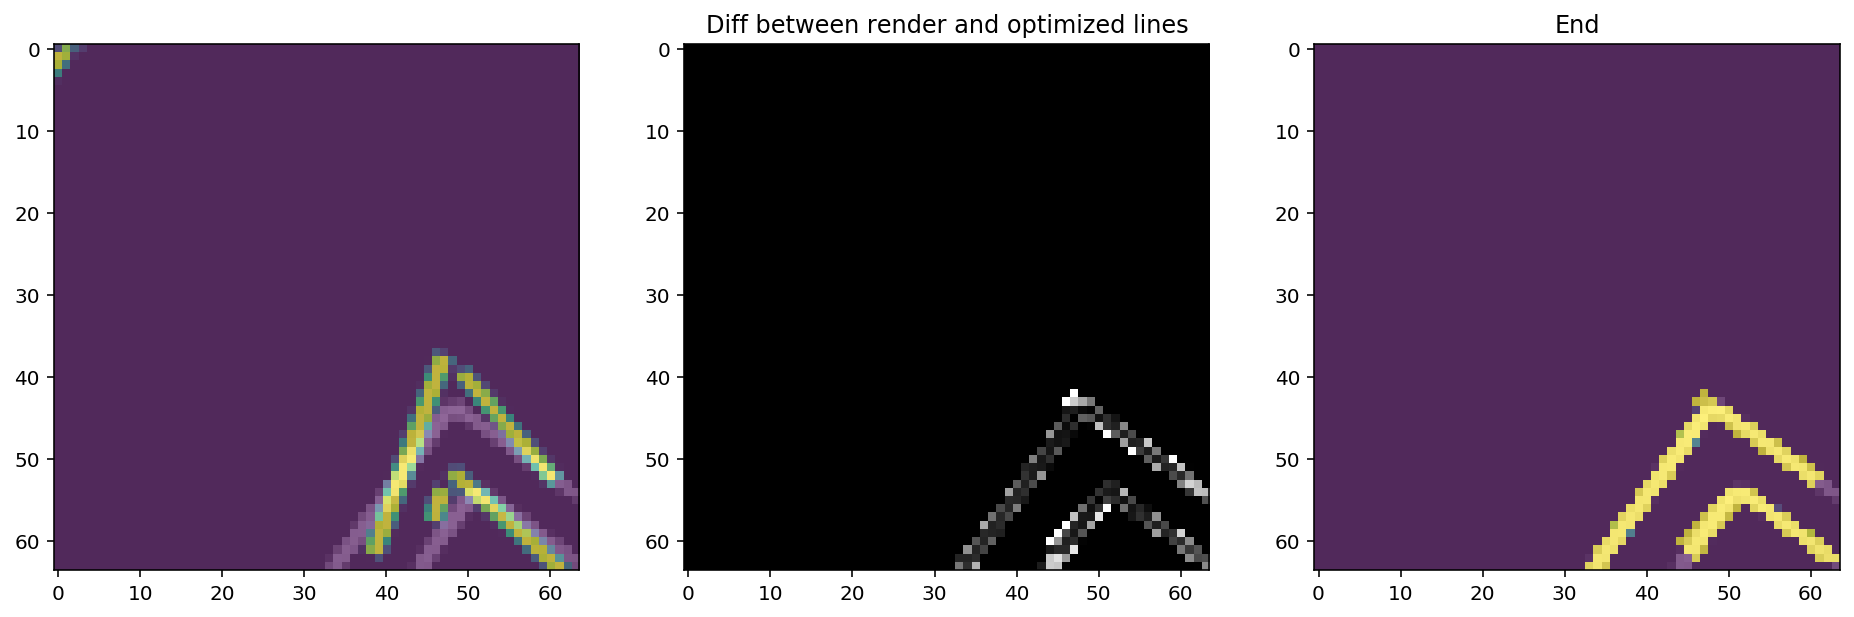

In [5]:
for i, (raster, render) in enumerate(zip(aligner.state['raster'], aligner.state['render'])):
    raster = raster.detach().cpu().numpy()
    render = render.detach().cpu().numpy()
    
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    initial = SyntheticPatch.from_lines(torch_to_synthetic_lines(aligner.state['initial_line_batch'][i].detach().cpu())).get_image()
    plt.imshow(initial, alpha=0.6)
    plt.subplot(1, 3, 2)
    plt.title('Diff between render and optimized lines')
    plt.imshow(np.abs(aligner.state['difference'][i].detach().cpu().numpy()), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    plt.title('End')
    plt.imshow(aligner.state['render'][i].detach().cpu().numpy(), alpha=0.6)
    plt.show()

In [26]:
aligner.state['current_line_batch']

tensor([[[-9.7099e-01,  5.8744e+01,  3.8110e+01,  4.9242e+01,  2.0730e+00,
           1.0000e+00],
         [-3.7861e+00,  5.4729e+01,  3.1184e+01,  4.6217e+01,  2.1869e+00,
           1.0000e+00],
         [-9.6325e-01,  6.3284e+01,  6.4937e+01,  4.7299e+01,  2.2764e+00,
           1.0000e+00],
         ...,
         [ 4.4329e+01,  5.3101e+01,  4.6329e+01,  6.5392e+01,  5.5989e+00,
           1.0000e+00],
         [ 3.7816e+01,  4.9180e+01,  6.4349e+01,  4.2494e+01,  2.1634e+00,
           1.0000e+00],
         [-6.0000e+00, -3.0000e+00, -3.0000e+00, -3.0000e+00,  1.0000e+00,
           0.0000e+00]],

        [[-2.0746e+00,  4.6834e+01,  3.9271e+01,  5.5680e+00,  5.5717e+00,
           1.0000e+00],
         [ 3.7399e+01,  8.7066e+00,  3.6676e+01, -1.8525e-01,  3.5460e+00,
           1.0000e+00],
         [ 2.0000e+00, -2.0000e+00,  1.0000e+00,  2.0000e+00,  1.0000e+00,
           0.0000e+00],
         ...,
         [ 2.0000e+00, -1.0000e+00,  0.0000e+00, -4.0000e+00,  1.0000e+00,
    

In [27]:
bce_loss = torch.nn.BCEWithLogitsLoss(reduction='none')

In [28]:
bce_loss(aligner.state['render'], aligner.state['raster']).mean(dim=(1, 2))

tensor([0.7029, 0.6820, 0.7033, 0.7243, 0.7020, 0.7024, 0.6960, 0.6759, 0.6897,
        0.6929, 0.6946, 0.6932, 0.6987, 0.6982, 0.6899, 0.6819, 0.6975, 0.6948,
        0.7032, 0.7008, 0.6871, 0.7016, 0.6948, 0.6876, 0.6884, 0.6677, 0.7046,
        0.6963, 0.6866, 0.7029, 0.6917, 0.6891], device='cuda:1',
       grad_fn=<MeanBackward1>)